# Preliminaries

In [1]:
!pip install e2cnn

  Using cached https://files.pythonhosted.org/packages/a1/4d/05b0dd45848e41c1b5e93755682a9e593f19a92e01aeb57b327f15881e3f/e2cnn-0.2.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d0/04/66be21ceb305c66a4b326b0ae44cc4f027a43bc08cac204b48fb45bb3653/sympy-1.10.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/00/86/77a9eddbf46f1bca2468d16a401911f58917f95b63402d6a7a4522521e5d/torch-1.13.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/58/4f/11f34cfc57ead25752a7992b069c36f5d18421958ebd6466ecd849aeaf86/scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/6d/ad/ff3b21ebfe79a4d25b4a4f8e5cf9fd44a204adb6b33c09010f566f51027a/numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/43/e3/7d92a15f894aa0c9c4b49b8ee9ac9850d6e63b03c9c32c0367a13ae62209/mpmath-1.3.0-py3-none-

In [1]:
from e2cnn import gspaces
import e2cnn.nn

In [3]:
!pip install higher

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt

import string
#import random
import os

from torch.nn import init

import collections
#import torch
from torch.optim import SGD, Adam

import higher
import time
import scipy.stats as st

In [3]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [4]:
#import string
#import random
#import os


def get_random_string(length):
    # Random string with the combination of lower and upper case
    letters = string.ascii_letters
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

DATASET = 'rot-mnist'
HIDDENS = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
TRIAL_ID =  os.environ.get('NNI_TRIAL_JOB_ID', get_random_string(5))
EXP_DIR = './checkpoints/{}'.format(TRIAL_ID)

''' Example of a configuration
config = {
    # ---COMMON----
    'num_tasks': 5, 'per_task_rotation': 9, 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64
}
'''

" Example of a configuration\nconfig = {\n    # ---COMMON----\n    'num_tasks': 5, 'per_task_rotation': 9, 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,    'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,    'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,    'batch_size': 64\n}\n"

## RotatedMNISTDataset

This class provides MNIST images with random rotations sampled from
a list of rotation angles. This list is dependent of the number of tasks
`num_tasks` and the distance (measured in degrees) between tasks
`per_task_rotation`.

In [5]:
class RotatedMNISTDataset(Dataset):
    '''
        This class provides MNIST images with random rotations sampled from
        a list of rotation angles. This list is dependent of the number of tasks
        `num_tasks` and the distance (measured in degrees) between tasks
        `per_task_rotation`.
    '''
    def __init__(self, root, train=True, transform=None, download=True, num_tasks=5, per_task_rotation=9):
        self.dataset = torchvision.datasets.MNIST(root=root, train=train, transform=transform, download=download)
        self.transform = transform
        self.rotation_angles = []
        for task in range(num_tasks):
            self.rotation_angles.append(float((task-1) * per_task_rotation))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        angle = np.random.choice(self.rotation_angles)  # Randomly choose a rotation angle
        rotated_image = F.rotate(image, angle, fill=(0,))
        return rotated_image, label, angle

In [6]:
def plot_class_distribution(dataset, title):
    labels = [label for _, label, _ in dataset]
    unique_labels, counts = torch.unique(torch.tensor(labels), return_counts=True)

    plt.bar(unique_labels, counts, align='center', alpha=0.7)
    plt.xticks(unique_labels)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

def plot_angle_distribution(dataset, title):
    angles = [angle for _, _, angle in dataset]
    unique_angles, counts = torch.unique(torch.tensor(angles), return_counts=True)

    plt.bar(unique_angles, counts, align='center', alpha=0.7)
    plt.xticks(unique_angles)
    plt.xlabel('Angle')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

### Test RotatedMNISTDataset

In [10]:
config = {
    # ---COMMON----
    'num_tasks': 5, 'per_task_rotation': 9, 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64
}

In [ ]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_5deg = RotatedMNISTDataset('./data', train=True, transform=transforms,
                                    num_tasks=config['num_tasks'],
                                    per_task_rotation=config['per_task_rotation'])
test_5deg = RotatedMNISTDataset('./data', train=False, transform=transforms,
                                    num_tasks=config['num_tasks'],
                                    per_task_rotation=config['per_task_rotation'])

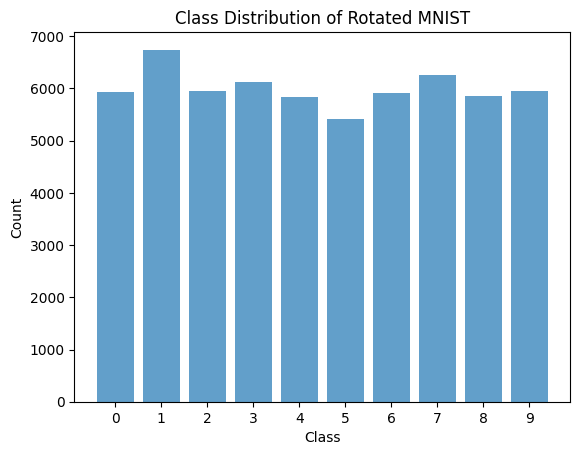

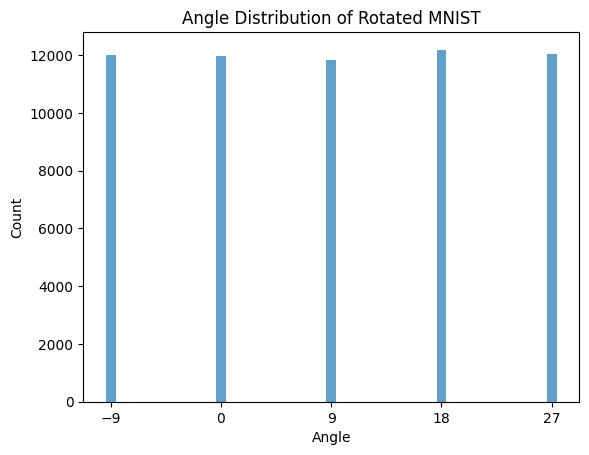

In [ ]:
plot_class_distribution(train_5deg, title='Class Distribution of Rotated MNIST')
plot_angle_distribution(train_5deg, title='Angle Distribution of Rotated MNIST')

## create_rotated_mnist_task

`create_rotated_mnist_task` creates a series of `num_tasks` data loaders each containing mnist images rotated with a single rotation angle. The rotation angles of successive data loaders are separated by `per_task_rotation` degrees.

In [7]:
class RotationTransform:
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, x):
        return F.rotate(x, self.angle, fill=(0,))

def create_rotated_mnist_task(num_tasks, per_task_rotation, batch_size, transform=[]):
    train_loaders = []
    test_loaders = []

    g = torch.Generator()
    g.manual_seed(0)  # check: always setting generator to 0 ensures the same ordering of data

    for task in range(num_tasks):
        rotation_degree = (task-1) * per_task_rotation

        extended_transform = transform.copy()
        extended_transform.extend([
            RotationTransform(rotation_degree),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])
        transforms = torchvision.transforms.Compose(extended_transform)
        #print(transforms)

        train = torchvision.datasets.MNIST('./data/', train=True, download=True, transform=transforms)
        test = torchvision.datasets.MNIST('./data/', train=False, download=True, transform=transforms)

        train_loader = torch.utils.data.DataLoader(train,  batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, generator=g)
        test_loader = torch.utils.data.DataLoader(test,  batch_size=256, shuffle=True, num_workers=0, pin_memory=True, generator=g)

        train_loaders.append({
            'loader':train_loader,
            'task':task,
            'rot':rotation_degree})
        test_loaders.append({
            'loader':test_loader,
            'task':task,
            'rot':rotation_degree})

    return train_loaders, test_loaders


In [8]:
def plot_rotated_mnist_images(dataloader, task, rotation_degree, num_images=5):
    plt.figure(figsize=(15, 3))

    b = next(iter(dataloader))[0]
    rng = np.random.default_rng()
    images = rng.choice(b, size=num_images, replace=False)

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i, 0], cmap='gray')
        plt.title(f'Angle: {rotation_degree}°')
        plt.axis('off')

    plt.show()

'''
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(25):
        ax = axes[i//num_row, i%num_col]
        ax.imshow(data[i].numpy()[0], cmap='gray')
        ax.set_title('Task: {}'.format(task_id))
    plt.tight_layout()
    plt.savefig('datasets.png', dpi=300)
'''

"\n    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))\n    for i in range(25):\n        ax = axes[i//num_row, i%num_col]\n        ax.imshow(data[i].numpy()[0], cmap='gray')\n        ax.set_title('Task: {}'.format(task_id))\n    plt.tight_layout()\n    plt.savefig('datasets.png', dpi=300)\n"

### Test create_rotated_mnist_task

In [11]:
train_loaders, test_loaders = create_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])

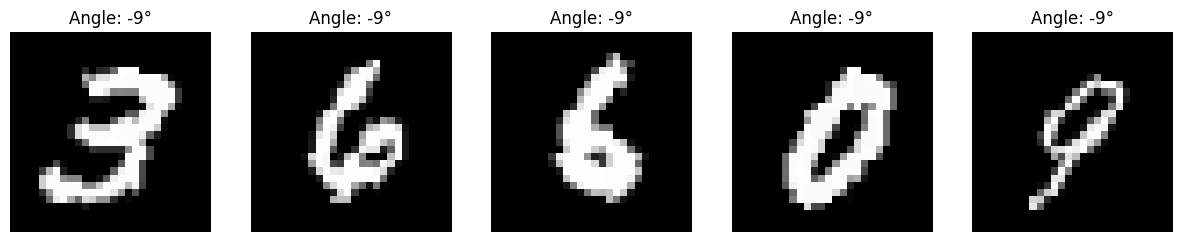

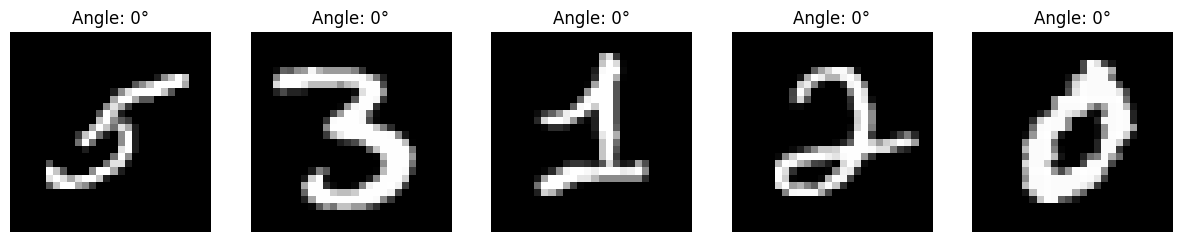

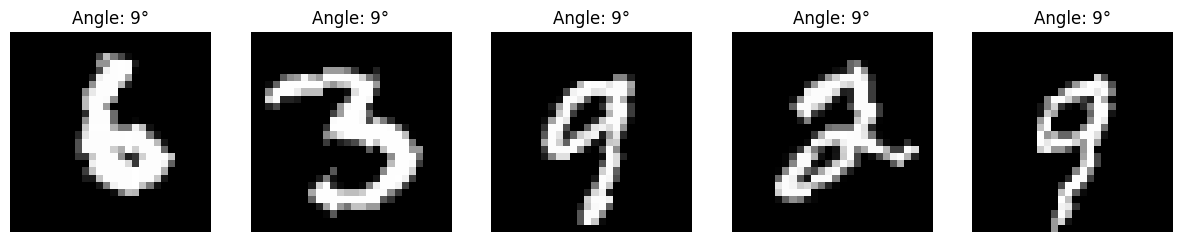

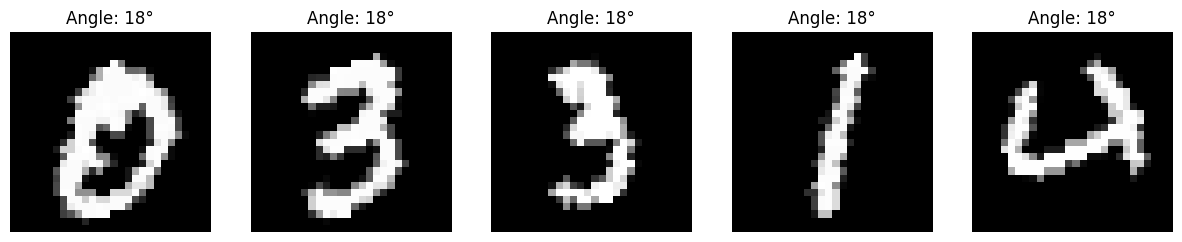

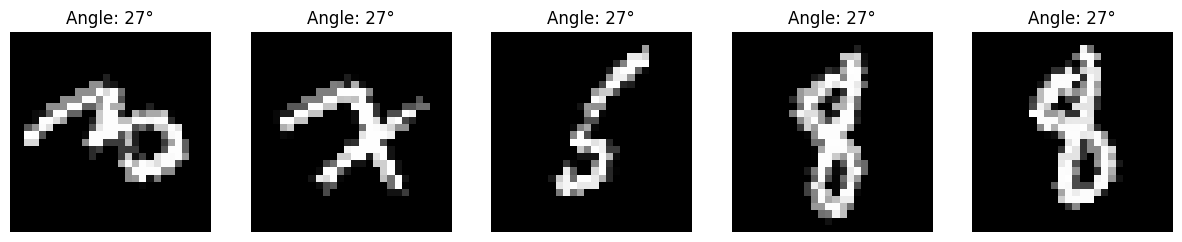

In [12]:
for train_loader in train_loaders:
    plot_rotated_mnist_images(train_loader['loader'], train_loader['task'], train_loader['rot'], num_images=5)

# Definition of models

## [model] **MLP**: Two layer MLP for MNIST benchmarks

In [ ]:
class MLP(nn.Module):
    """
    Two layer MLP for MNIST benchmarks.
    """
    def __init__(self, config):
        super(MLP, self).__init__()
        self.save_acts = False
        self.acts = {}
        self.config = config
        self.W1 = nn.Linear(784, config['mlp_hiddens'])
        self.dropout_1 =  nn.Dropout(p=config['dropout'])
        self.relu = nn.ReLU(inplace=True)
        self.W2 = nn.Linear(config['mlp_hiddens'], config['mlp_hiddens'])
        self.dropout_2 =  nn.Dropout(p=config['dropout'])

        self.W3 = nn.Linear(config['mlp_hiddens'], 10)
        # self.dropout_p = config['dropout']

    def forward(self, x, task_id=None):
        # x = x.view(-1, 784 + self.num_condition_neurons)
        x = x.view(-1, 784)
        out = self.W1(x)
        out = self.relu(out)

        if self.save_acts:
            self.acts['layer 1'] = out.detach().clone()

        if self.config['dropout'] > 0:
            out = self.dropout_1(out)
        out = self.W2(out)
        out = self.relu(out)
        if self.save_acts:
            self.acts['layer 2'] = out.detach().clone()
        if self.config['dropout'] > 0:
            out = self.dropout_2(out)
        # out = nn.functional.dropout(out, p=self.dropout_p)
        out = self.W3(out)
        return out

## [model] **SimpleNN**: Simple neural network

In [13]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## [model] **Net**: CNN from pytorch documentation

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = torch.nn.functional.log_softmax(x, dim=1)
        return output

## [model] **e2cnn**: General E(2)-Equivariant Steerable CNNs

from https://github.com/QUVA-Lab/e2cnn/blob/master/examples/model.ipynb

**NB** the model is equivariant under rotations by 45 degrees, modelled by C8



In [ ]:
#!pip install e2cnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 4.1 MB/s eta 0:00:00


In [ ]:
#from e2cnn import gspaces
#import e2cnn.nn

In [ ]:
class C8SteerableCNN(torch.nn.Module):

    def __init__(self, n_classes=10):

        super(C8SteerableCNN, self).__init__()

        # the model is equivariant under rotations by 45 degrees, modelled by C8
        self.r2_act = gspaces.Rot2dOnR2(N=8)

        # the input image is a scalar field, corresponding to the trivial representation
        in_type = e2cnn.nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])

        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type

        # convolution 1
        # first specify the output type of the convolutional layer
        # we choose 24 feature fields, each transforming under the regular representation of C8
        out_type = e2cnn.nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block1 = e2cnn.nn.SequentialModule(
            e2cnn.nn.MaskModule(in_type, 29, margin=1),
            e2cnn.nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, stride=3, bias=False),
            e2cnn.nn.InnerBatchNorm(out_type),
            e2cnn.nn.ReLU(out_type, inplace=True)
        )

        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 48 regular feature fields of C8
        out_type = e2cnn.nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block2 = e2cnn.nn.SequentialModule(
            e2cnn.nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, stride=3, bias=False),
            e2cnn.nn.InnerBatchNorm(out_type),
            e2cnn.nn.ReLU(out_type, inplace=True)
        )

        self.pool1 = e2cnn.nn.SequentialModule(
            e2cnn.nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=3)
        )

        '''
        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 48 regular feature fields of C8
        out_type = e2cnn.nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block3 = e2cnn.nn.SequentialModule(
            e2cnn.nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            e2cnn.nn.InnerBatchNorm(out_type),
            e2cnn.nn.ReLU(out_type, inplace=True)
        )

        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 96 regular feature fields of C8
        out_type = e2cnn.nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block4 = e2cnn.nn.SequentialModule(
            e2cnn.nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            e2cnn.nn.InnerBatchNorm(out_type),
            e2cnn.nn.ReLU(out_type, inplace=True)
        )
        self.pool2 = e2cnn.nn.SequentialModule(
            e2cnn.nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields of C8
        out_type = e2cnn.nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block5 = e2cnn.nn.SequentialModule(
            e2cnn.nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            e2cnn.nn.InnerBatchNorm(out_type),
            e2cnn.nn.ReLU(out_type, inplace=True)
        )

        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields of C8
        out_type = e2cnn.nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr])
        self.block6 = e2cnn.nn.SequentialModule(
            e2cnn.nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            e2cnn.nn.InnerBatchNorm(out_type),
            e2cnn.nn.ReLU(out_type, inplace=True)
        )
        self.pool3 = e2cnn.nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)
        '''

        self.gpool = e2cnn.nn.GroupPooling(out_type)

        # number of output channels
        c = self.gpool.out_type.size
        print('c=', c)

        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(c, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )

    def forward(self, input: torch.Tensor):
        #print(input.shape)  # INITIAL MODEL torch.Size([1, 1, 29, 29])

        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = e2cnn.nn.GeometricTensor(input, self.input_type)
        #print(x.shape)  # INITIAL MODEL torch.Size([1, 1, 29, 29])

        # apply each equivariant block

        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # The Layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)
        #print(x.shape)  # INITIAL MODEL torch.Size([1, 384, 13, 13])

        '''
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        print(x.shape)  # torch.Size([1, 768, 7, 7])

        x = self.block5(x)
        x = self.block6(x)
        print(x.shape)  # INITIAL MODEL torch.Size([1, 512, 5, 5])

        # pool over the spatial dimensions
        x = self.pool3(x)
        print(x.shape)  # INITIAL MODEL torch.Size([1, 512, 1, 1])
        '''

        # pool over the group
        x = self.gpool(x)
        #print(x.shape)  # INITIAL MODEL torch.Size([1, 64, 1, 1])


        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor

        # classify with the final fully connected layers)
        x = self.fully_net(x.reshape(x.shape[0], -1))

        return x

## [model] **MSR**: Metalearning Symmetries by Reparameterization using ShareConv2d layer

In [10]:
#from torch.nn import init


class ShareConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, sigmoid=False, **kwargs):
        self.sigmoid = sigmoid
        self.A_warp, self.B_warp, self.C_warp = None, None, None
        super(ShareConv2d, self).__init__(in_channels, out_channels, kernel_size, **kwargs)
        k_size = int(np.prod(self.kernel_size))
        self.A_warp = nn.Parameter(torch.eye(self.out_channels, self.out_channels))
        self.B_warp = nn.Parameter(torch.eye(self.in_channels, self.in_channels))
        self.C_warp = nn.Parameter(torch.eye(k_size, k_size))
        if self.sigmoid:
            self.temp_warp = nn.Parameter(torch.rand(1))
        self.reset_parameters()

    def reset_parameters(self):
        super(ShareConv2d, self).reset_parameters()
        if self.A_warp is not None:
            self.reset_warp_parameters()

    def reset_warp_parameters(self):
        init._no_grad_fill_(self.A_warp, 0.0)
        init._no_grad_fill_(self.B_warp, 0.0)
        init._no_grad_fill_(self.C_warp, 0.0)
        if self.sigmoid:
            init._no_grad_fill_(self.temp_warp, 7.0)
            init._no_grad_fill_(self.A_warp, -1.0)
            init._no_grad_fill_(self.B_warp, -1.0)
            init._no_grad_fill_(self.C_warp, -1.0)
        with torch.no_grad():
            self.A_warp.fill_diagonal_(1.0)
            self.B_warp.fill_diagonal_(1.0)
            self.C_warp.fill_diagonal_(1.0)

    def forward(self, x):
        A_warp, B_warp, C_warp = self.A_warp, self.B_warp, self.C_warp
        if self.sigmoid:
            A_warp = torch.sigmoid(self.temp_warp * A_warp)
            B_warp = torch.sigmoid(self.temp_warp * B_warp)
            C_warp = torch.sigmoid(self.temp_warp * C_warp)
        orig_shape = self.weight.shape
        # (c_o, c_i, k_w * k_h)
        weight = torch.reshape(self.weight, (self.out_channels, self.in_channels, -1))
        weight = torch.einsum("ij,jkl->ikl", A_warp, weight)
        weight = torch.einsum("ik,jkl->jil", B_warp, weight)
        weight = torch.einsum("il,jkl->jki", C_warp, weight)
        weight = torch.reshape(weight, orig_shape)
        return self._conv_forward(x, weight, bias=self.bias)  #MH


class MSR(torch.nn.Module):
    def __init__(self):
        super(MSR, self).__init__()
        self.shareconv1 = ShareConv2d(1, 32, 3, bias=False)
        self.shareconv2 = ShareConv2d(32, 64, 3, bias=False)
        #self.conv1 = nn.Conv2d(1, 32, 3, 1)
        #self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.shareconv1(x)
        #x = self.conv1(x)
        x = torch.nn.functional.relu(x)

        x = self.shareconv2(x)
        #x = self.conv2(x)
        x = torch.nn.functional.relu(x)

        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout2(x)

        x = self.fc2(x)
        output = torch.nn.functional.log_softmax(x, dim=1)
        return output

# Training and evaluation methods

In [104]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    loss_canonical = []
    for epoch in range(num_epochs):
        print('epoch', epoch)
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_canonical.append(loss.detach().numpy())

    return loss_canonical

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [ ]:
#model = MLP(config)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=config['momentum'])
#criterion = criterion = nn.CrossEntropyLoss()
#loss = train_model(model, train_loaders[0][0], criterion, optimizer, num_epochs=5)

# Rotated MNIST: a separate model for each angle (task)

## Utility functions

In [18]:
def plot_losses(losses, config):
    for loss in losses:
        plt.plot(loss['train_loss'], label=str(loss['rot'])+"°")

        plt.title('Training loss vs. Number of training steps')
        plt.xlabel('Number of training steps')
        plt.ylabel('Training loss')
        #plt.xscale('log')
        plt.legend()
        filename = '{}_{}_{}deg_training-loss-vs-number-of-training-steps-MNIST.pdf'.format(
            config['setting'],
            config['model_name'],
            loss['rot']
        )
        plt.savefig(filename)
        plt.show()


In [30]:
def plot_accuracies(accuracies, config):
    rots, accs = [], []
    for d in accuracies:
        rots.append(d['rot'])
        accs.append(d['test_acc'])

    plt.plot(rots, accs, color='b', marker='o')
    ticks = rots



    plt.title('Evaluation accuracy vs. Rotation angle')
    plt.xlabel('Rotation angle (task)')
    plt.ylabel('Evaluation accuracy')
    plt.xticks(ticks, ticks)
    #plt.xscale('log')
    #plt.legend()
    #plt.grid()
    plt.savefig(config['setting']+'_'+config['model_name']+'_evaluation-accuracy-vs-rotation-angle-MNIST-'+str(config['per_task_rotation'])+'deg.pdf')
    plt.show()

## SimpleNN model

In [48]:
config = {
    # ---COMMON----
    'setting': 'SeparateModel',
    'model_name': 'SimpleNN',
    'num_tasks': 8, 'per_task_rotation': 45, 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64,\
    'rounds': 10
}

### Training

In [23]:
train_loaders, test_loaders = create_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])

accuracy_history_canonical = []
losses_canonical = []

for train_loader, test_loader in zip(train_loaders, test_loaders):
    print("training A NEW MODEL with Rotated MNIST angle", train_loader['rot'], "°...")

    # Define the neural network, criterion, and optimizer
    model = SimpleNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Select a subset of training examples
    #indices = torch.randperm(len(train_dataset))[:num_examples]
    #train_subset = torch.utils.data.Subset(train_dataset, indices)

    #plot_class_distribution(train_subset, title='Class Distribution of MNIST Subset')

    #train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    #test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    lc = train_model(model, train_loader['loader'], criterion, optimizer)
    losses_canonical.append({'train_loss':lc, 'rot': train_loader['rot']})

    accuracy = evaluate_model(model, test_loader['loader'])
    accuracy_history_canonical.append({'test_acc':accuracy, 'rot':train_loader['rot']})


training A NEW MODEL with Rotated MNIST angle -45 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training A NEW MODEL with Rotated MNIST angle 0 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training A NEW MODEL with Rotated MNIST angle 45 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training A NEW MODEL with Rotated MNIST angle 90 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training A NEW MODEL with Rotated MNIST angle 135 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training A NEW MODEL with Rotated MNIST angle 180 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training A NEW MODEL with Rotated MNIST angle 225 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training A NEW MODEL with Rotated MNIST angle 270 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4


### Plotting training process

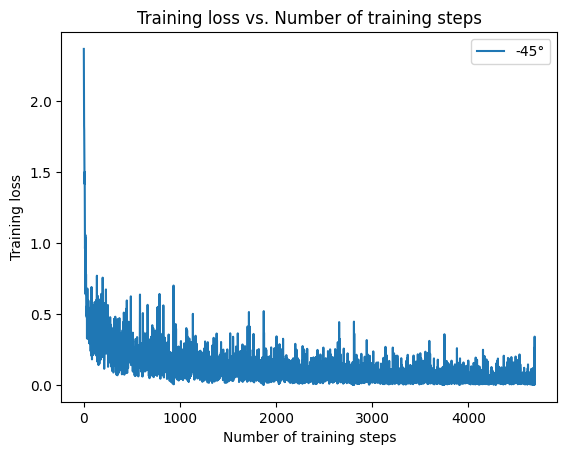

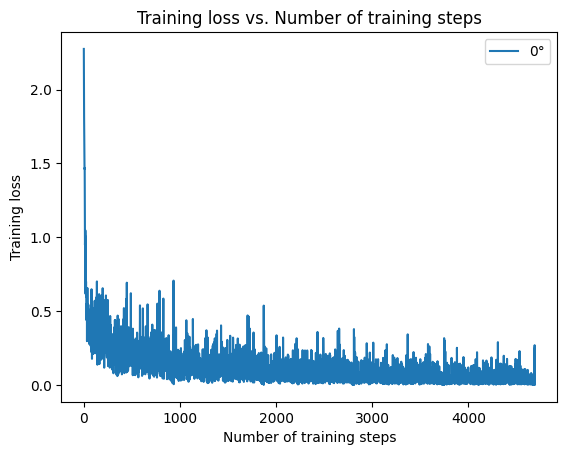

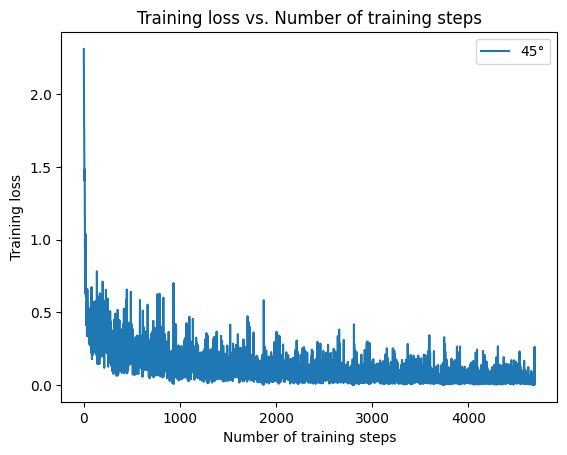

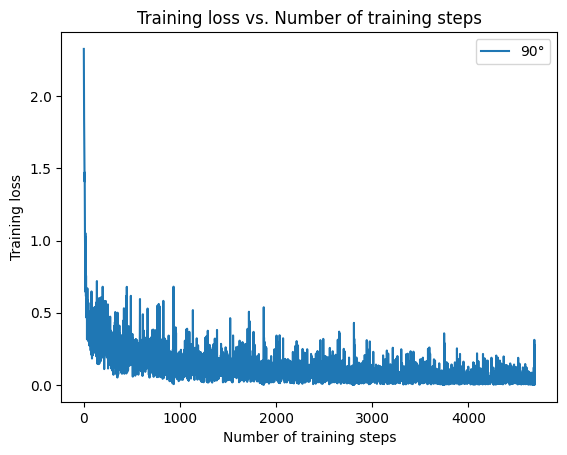

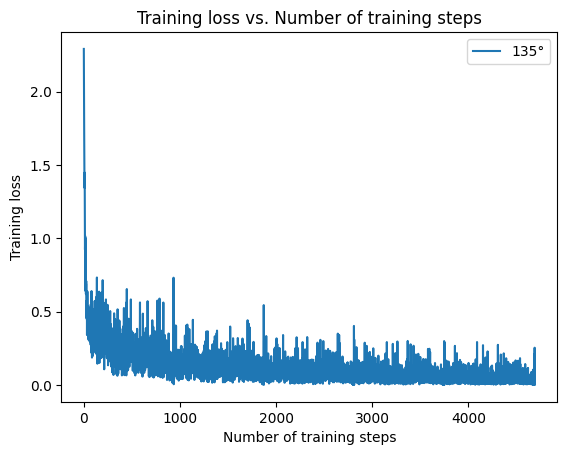

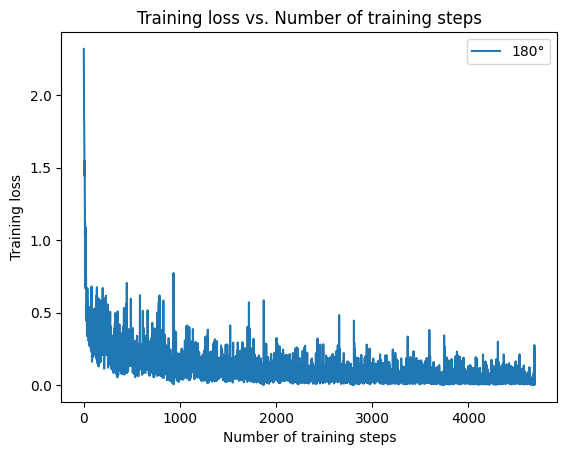

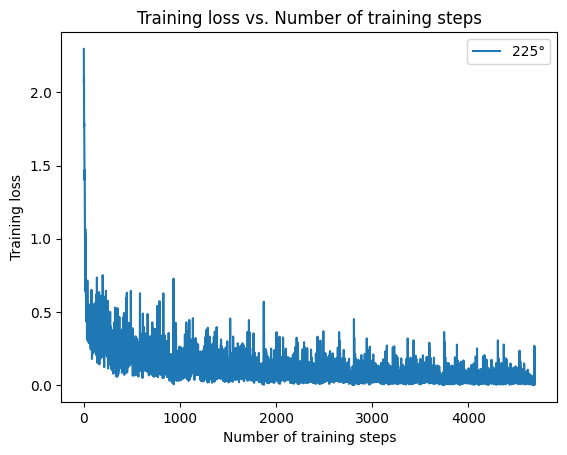

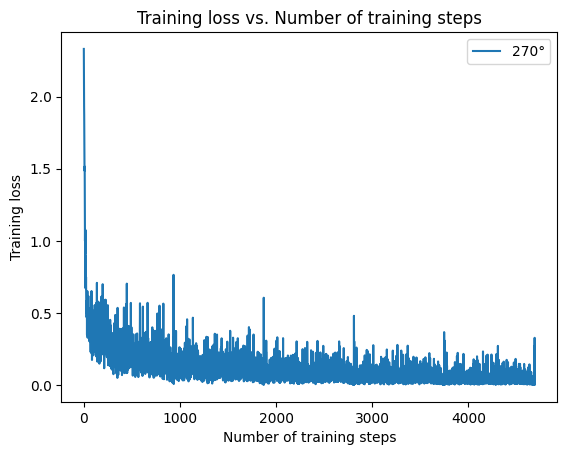

In [27]:
plot_losses(losses_canonical, config)

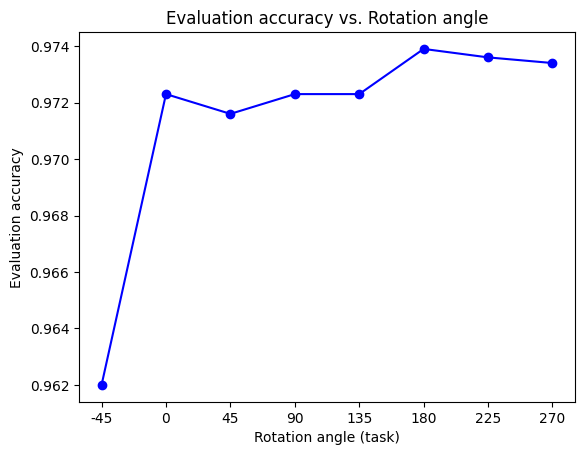

In [37]:
plot_accuracies(accuracy_history_canonical, config)

### Multiple runs

In [32]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [34]:
train_loaders, test_loaders = create_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])

accs_over_rotangles_and_runs = {} 
train_losses_over_rotangles_and_runs = {}

rounds = config['rounds']
for seed in range(rounds):
    set_seed(seed)

    for train_loader, test_loader in zip(train_loaders, test_loaders):
        print("training A NEW MODEL with Rotated MNIST angle", train_loader['rot'], "°...")

        # Define the neural network, criterion, and optimizer
        model = SimpleNN()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_loss = train_model(model, train_loader['loader'], criterion, optimizer)
        train_losses_over_rotangles_and_runs.setdefault(train_loader['rot'], []).append(train_loss)

        accuracy = evaluate_model(model, test_loader['loader'])
        accs_over_rotangles_and_runs.setdefault(test_loader['rot'], []).append(accuracy)



Random seed set as 0
training A NEW MODEL with Rotated MNIST angle -45 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training A NEW MODEL with Rotated MNIST angle 0 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training A NEW MODEL with Rotated MNIST angle 45 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training A NEW MODEL with Rotated MNIST angle 90 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training A NEW MODEL with Rotated MNIST angle 135 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training A NEW MODEL with Rotated MNIST angle 180 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training A NEW MODEL with Rotated MNIST angle 225 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training A NEW MODEL with Rotated MNIST angle 270 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Random seed set as 1
training A NEW MODEL with Rotated MNIST angle -45 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training A NEW MODEL with Rotated MNIST angle 0 °...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training A NEW

In [125]:
# import csv

# filename = '{}_{}_accs_over_rotangles_and_runs_{}deg_{}_runs.csv'.format(
#     config['setting'],
#     config['model_name'],
#     config['per_task_rotation'],
#     config['rounds']
# )
# with open(filename, 'w') as csvfile:
#     wr = csv.writer(csvfile)
#     rotangles, accs = zip(*accs_over_rotangles_and_runs.items())
#     wr.writerow(rotangles)
#     wr.writerows(accs)

import json

def save_accs(accs_dict, config, filename):
    with open(filename, 'w') as jsonfile:
        jsonfile.write(json.dumps(accs_dict))

print(accs_over_rotangles_and_runs)

{-45: [0.972, 0.9698, 0.9714, 0.9659, 0.9687, 0.9735, 0.9746, 0.9739, 0.9706, 0.9719], 0: [0.9715, 0.9733, 0.9683, 0.9703, 0.9696, 0.9712, 0.9743, 0.9734, 0.9731, 0.972], 45: [0.9734, 0.9708, 0.9703, 0.9659, 0.9716, 0.9693, 0.9742, 0.969, 0.968, 0.9718], 90: [0.9688, 0.9719, 0.9752, 0.969, 0.9747, 0.9687, 0.9704, 0.9677, 0.9744, 0.9662], 135: [0.9728, 0.9723, 0.9688, 0.973, 0.9753, 0.974, 0.9695, 0.9735, 0.973, 0.9696], 180: [0.9685, 0.9727, 0.97, 0.9693, 0.975, 0.9691, 0.9703, 0.9729, 0.9675, 0.9709], 225: [0.9707, 0.9718, 0.9641, 0.9683, 0.9711, 0.9689, 0.9713, 0.9718, 0.9716, 0.9673], 270: [0.9723, 0.9758, 0.9709, 0.9745, 0.9733, 0.9753, 0.9762, 0.9702, 0.9708, 0.9656]}


In [ ]:
filename = '{}_{}_accs_over_rotangles_and_runs_{}deg_{}_runs.json'.format(
    config['setting'],
    config['model_name'],
    config['per_task_rotation'],
    config['rounds']
)
save_accs(accs_over_rotangles_and_runs, config, filename=filename)

In [123]:
def plot_accuracies_mean_std(accuracies, config, title='Evaluation accuracy vs. Rotation angle', xlabel='Rotation angle (task)'):
    rots = accuracies.keys()
    means = []
    stds = []
    for rot, accs in accuracies.items():
        means.append(np.mean(accs))
        stds.append(np.std(accs))

    plt.errorbar(rots, means, yerr=stds, capsize=4, elinewidth=1, markeredgewidth=1, fmt='-o')
    #plt.plot(rots, accs, color='b', marker='o')
    ticks = list(rots)
    print(ticks)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Evaluation accuracy')
    plt.xticks(ticks, ticks)
    #plt.xscale('log')
    #plt.legend()
    #plt.grid()
    plt.savefig(config['setting']+'_'+config['model_name']+'_evaluation-accuracy-vs-rotation-angle-MNIST-'+str(config['per_task_rotation'])+'deg_'+str(config['rounds'])+'runs.pdf')
    plt.show()

[-45, 0, 45, 90, 135, 180, 225, 270]


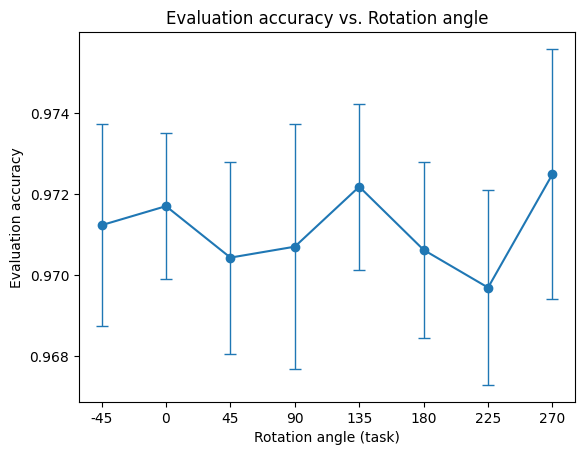

In [36]:
plot_accuracies_mean_std(accs_over_rotangles_and_runs, config)

In [95]:
def plot_losses_over_runs(train_losses_over_rotangles_and_runs, config):
    for rotangle, losses in train_losses_over_rotangles_and_runs.items():
        mean_losses = np.mean(losses, axis=0)
        std_losses = np.std(losses, axis=0)
        #print(mean_losses[0])
        #print(std_losses[0])

        plt.plot(list(range(len(mean_losses))), mean_losses)
        plt.fill_between(list(range(len(mean_losses))), mean_losses-2*std_losses, mean_losses+2*std_losses, color='#888888', alpha=0.4)


        plt.title('Training loss vs. Number of training steps')
        plt.xlabel('Number of training steps')
        plt.ylabel('Training loss')
        #plt.xscale('log')
        #plt.legend()
        filename = '{}_{}_{}deg_training-loss-vs-number-of-training-steps-MNIST.pdf'.format(
            config['setting'],
            config['model_name'],
            rotangle 
        )
        plt.savefig(filename)
        plt.show()



2.307779
0.027663384


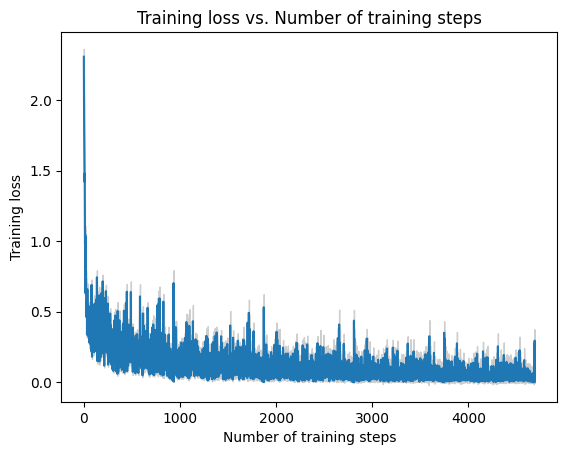

2.32944
0.023274431


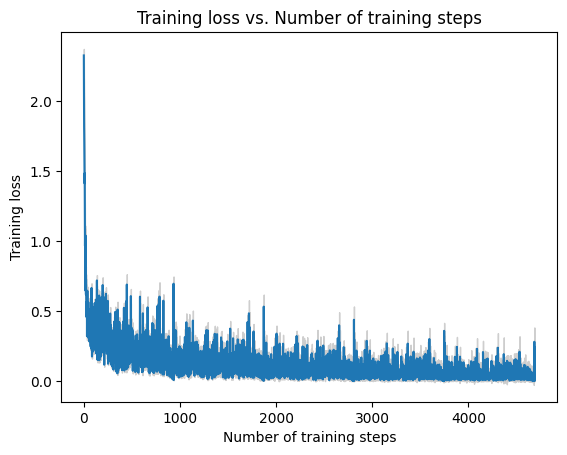

2.317982
0.015863566


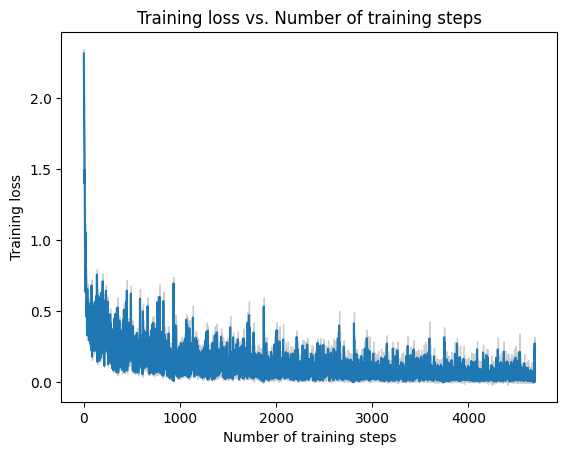

2.3222687
0.018707866


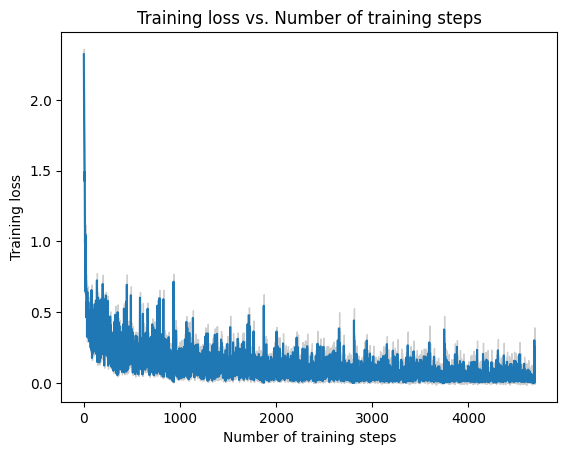

2.3232455
0.028969375


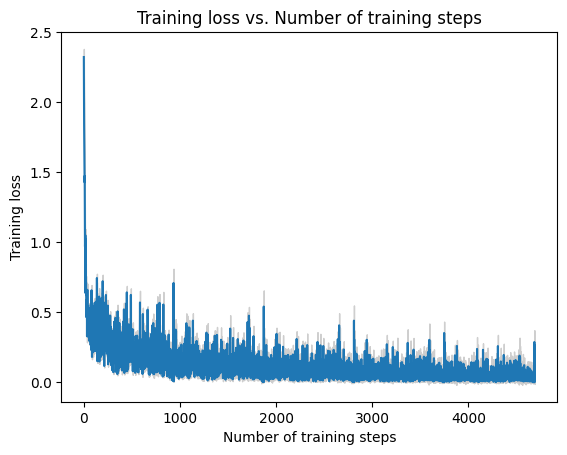

2.3290756
0.03807303


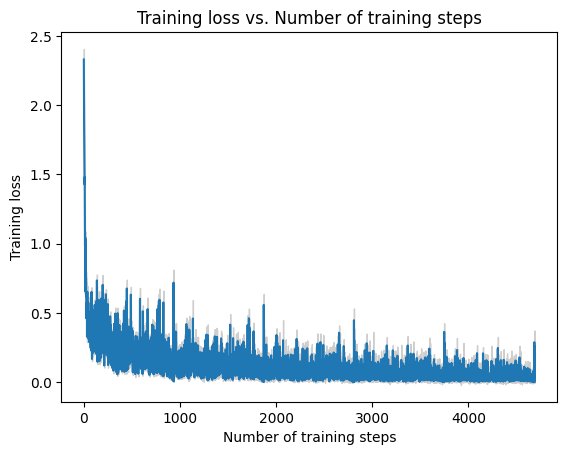

2.314279
0.038336866


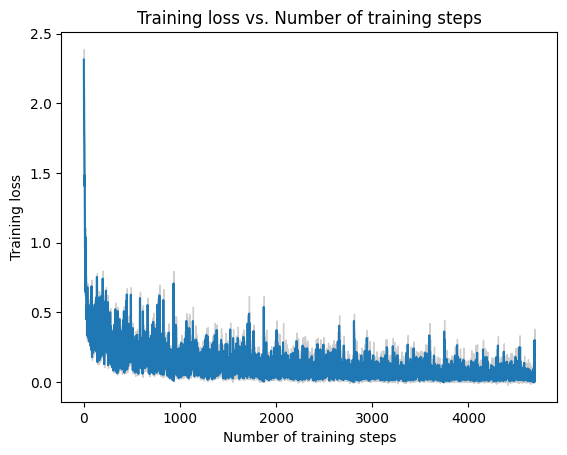

2.3268745
0.030514529


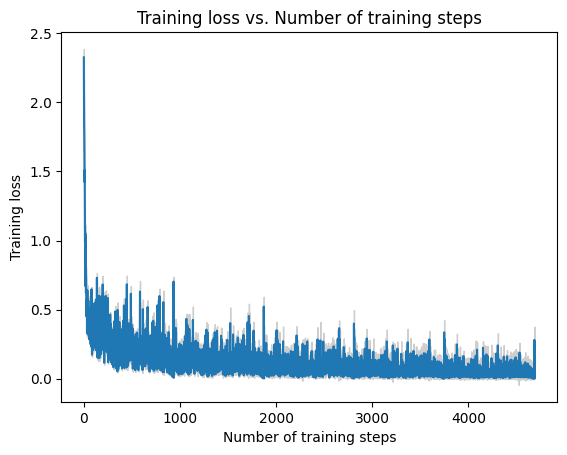

In [96]:
plot_losses_over_runs(train_losses_over_rotangles_and_runs, config)

In [ ]:
print(train_losses_over_rotangles_and_runs[45][0])

## Net (SimpleCNN)

In [ ]:
config = {
    # ---COMMON----
    'setting': 'SeparateModel',
    'model_name': 'SimpleCNN',
    'num_tasks': 8, 'per_task_rotation': 45, 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64,\
    'rounds': 10
}

### Multiple runs

In [ ]:
train_loaders, test_loaders = create_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])

accs_over_rotangles_and_runs = {} 
train_losses_over_rotangles_and_runs = {}

rounds = config['rounds']
for seed in range(rounds):
    set_seed(seed)

    for train_loader, test_loader in zip(train_loaders, test_loaders):
        print("training A NEW MODEL with Rotated MNIST angle", train_loader['rot'], "°...")

        # Define the neural network, criterion, and optimizer
        model = Net()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_loss = train_model(model, train_loader['loader'], criterion, optimizer)
        train_losses_over_rotangles_and_runs.setdefault(train_loader['rot'], []).append(train_loss)

        accuracy = evaluate_model(model, test_loader['loader'])
        accs_over_rotangles_and_runs.setdefault(test_loader['rot'], []).append(accuracy)



# Rotated MNIST: all rotations (tasks) flattened



## Utility functions

In [98]:
def plot_training_loss(lc, config):
    #plt.plot(loss, marker='o')
    plt.plot(lc)

    plt.title('Training loss vs. Number of training steps')
    plt.xlabel('Number of training steps')
    plt.ylabel('Training loss')
    plt.savefig(config['model_name']+'_training-loss-vs-number-of-training-steps-rotated-MNIST-'+str(config['per_task_rotation'])+'deg.pdf')
    plt.show()

In [105]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    loss_canonical = []
    for epoch in range(num_epochs):
        print('epoch', epoch)
        model.train()
        for inputs, labels, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_canonical.append(loss.detach().numpy())

    return loss_canonical

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels, _ in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

## SimpleNN model

### Warmup: training a first model (on 8 tasks with 45° per task)

In [100]:
config = {
    # ---COMMON----
    'setting': 'AllRotationsFlattened',
    'model_name': 'SimpleNN',
    'num_tasks': 8, 'per_task_rotation': 45, 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64,\
    'rounds': 10
}

In [ ]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_40deg = RotatedMNISTDataset('./data', train=True, transform=transforms,
                                    num_tasks=config['num_tasks'],
                                    per_task_rotation=config['per_task_rotation'])
test_40deg = RotatedMNISTDataset('./data', train=False, transform=transforms,
                                    num_tasks=config['num_tasks'],
                                    per_task_rotation=config['per_task_rotation'])

In [ ]:
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_40deg, batch_size=64, shuffle=True)
test_loader = DataLoader(test_40deg, batch_size=64, shuffle=False)

lc = train_model(model, train_loader, criterion, optimizer)
accuracy = evaluate_model(model, test_loader)

accuracy= 0.949


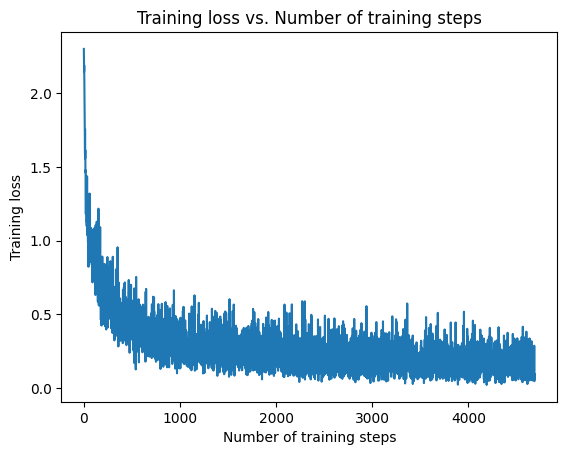

In [ ]:
print('accuracy=', accuracy)
plot_training_loss(lc, config)

#### Multiple runs

In [101]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [106]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train = RotatedMNISTDataset('./data', train=True, transform=transforms,
                                    num_tasks=config['num_tasks'],
                                    per_task_rotation=config['per_task_rotation'])
test = RotatedMNISTDataset('./data', train=False, transform=transforms,
                                    num_tasks=config['num_tasks'],
                                    per_task_rotation=config['per_task_rotation'])

train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

In [107]:
accs_over_runs = {} 
train_losses_over_runs = {}

rounds = config['rounds']
for seed in range(rounds):
    set_seed(seed)

    print("training A NEW MODEL with Rotated MNIST all angles flattened ...")

    # Define the neural network, criterion, and optimizer
    model = SimpleNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loss = train_model(model, train_loader, criterion, optimizer)
    train_losses_over_runs.setdefault('all angles flattened', []).append(train_loss)

    accuracy = evaluate_model(model, test_loader)
    accs_over_runs.setdefault('all angles flattened', []).append(accuracy)



Random seed set as 0
training A NEW MODEL with Rotated MNIST all angles flattened ...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Random seed set as 1
training A NEW MODEL with Rotated MNIST all angles flattened ...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Random seed set as 2
training A NEW MODEL with Rotated MNIST all angles flattened ...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Random seed set as 3
training A NEW MODEL with Rotated MNIST all angles flattened ...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Random seed set as 4
training A NEW MODEL with Rotated MNIST all angles flattened ...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Random seed set as 5
training A NEW MODEL with Rotated MNIST all angles flattened ...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Random seed set as 6
training A NEW MODEL with Rotated MNIST all angles flattened ...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Random seed set as 7
training A NEW MODEL with Rotated MNIST all angles flattened ...
epoch 0
epoch 1
epoch 2
epoch 3


2.3176053
0.032736022


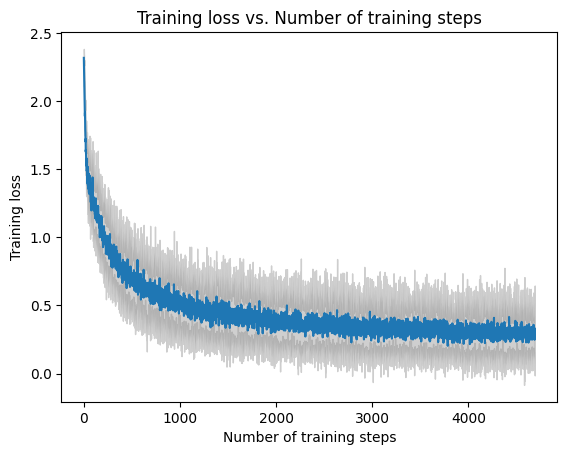

In [109]:
plot_losses_over_runs(train_losses_over_runs, config)

In [ ]:
print(train_losses_over_runs)

In [110]:
print(accs_over_runs)

{'all angles flattened': [0.9084, 0.9128, 0.9099, 0.9059, 0.9154, 0.9037, 0.9131, 0.9112, 0.9095, 0.9117]}


In [127]:
filename = '{}_{}_accs_over_runs_{}_runs.json'.format(
    config['setting'],
    config['model_name'],
    config['rounds']
)
save_accs(accs_over_runs, config, filename=filename)

### Accuracy vs. Number of tasks

**NB.** Distance between the first and last task is fixed to 180°

Here, we are kind of trying to evaluate how the models behave as a function of the granularity of data in the roation space from 0° to 180°

In [ ]:
losses = []
accuracies = []

for num_tasks in range(3, 20):
    config['num_tasks'] = num_tasks
    config['per_task_rotation'] = 180//num_tasks

    print('training a new model on ', config['num_tasks'], 'tasks')
    print('per task rotation in this situation is ', config['per_task_rotation'], 'deg')

    model = SimpleNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])

    train = RotatedMNISTDataset('./data', train=True, transform=transforms,
                                        num_tasks=config['num_tasks'],
                                        per_task_rotation=config['per_task_rotation'])
    test = RotatedMNISTDataset('./data', train=False, transform=transforms,
                                        num_tasks=config['num_tasks'],
                                        per_task_rotation=config['per_task_rotation'])

    train_loader = DataLoader(train, batch_size=64, shuffle=True)
    test_loader = DataLoader(test, batch_size=64, shuffle=False)

    losses.append(train_model(model, train_loader, criterion, optimizer))
    accuracies.append(evaluate_model(model, test_loader))

training a new model on  3 tasks
per task rotation in this situation is  60
training a new model on  4 tasks
per task rotation in this situation is  45
training a new model on  5 tasks
per task rotation in this situation is  36
training a new model on  6 tasks
per task rotation in this situation is  30
training a new model on  7 tasks
per task rotation in this situation is  25
training a new model on  8 tasks
per task rotation in this situation is  22
training a new model on  9 tasks
per task rotation in this situation is  20
training a new model on  10 tasks
per task rotation in this situation is  18
training a new model on  11 tasks
per task rotation in this situation is  16
training a new model on  12 tasks
per task rotation in this situation is  15
training a new model on  13 tasks
per task rotation in this situation is  13
training a new model on  14 tasks
per task rotation in this situation is  12
training a new model on  15 tasks
per task rotation in this situation is  12
traini

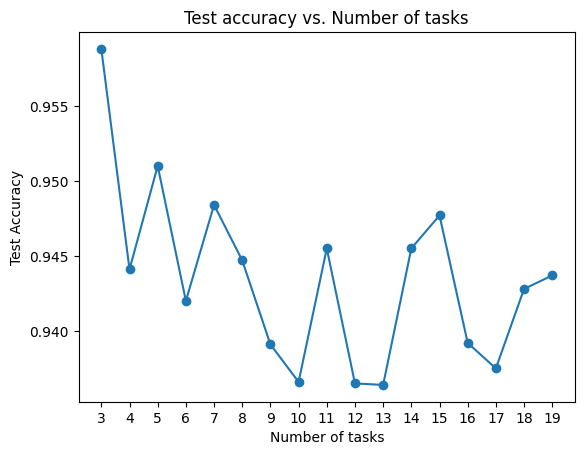

In [ ]:
plt.plot(list(range(3, 20)), accuracies, marker='o')
plt.title('Test accuracy vs. Number of tasks')
plt.xlabel('Number of tasks')
plt.ylabel('Test Accuracy')
plt.xticks(list(range(3, 20)))
plt.savefig('model-performance-vs-number-of-tasks-rotated-mnist.pdf')
plt.show()


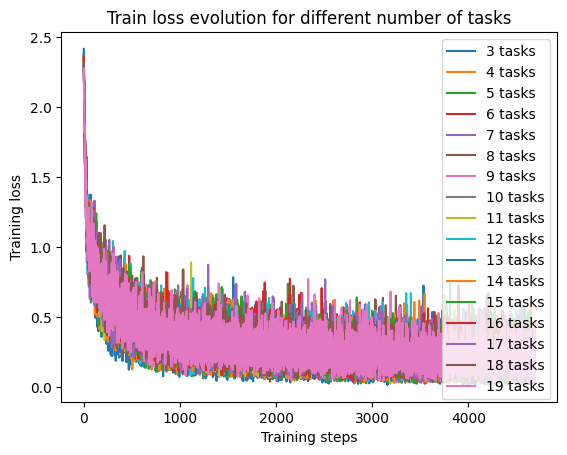

In [ ]:
for num_tasks, loss in zip(list(range(3, 20)), losses):
    plt.plot(loss, label=str(num_tasks)+' tasks')
plt.title('Train loss evolution for different number of tasks')
plt.xlabel('Training steps')
plt.ylabel('Training loss')
plt.legend()
plt.savefig('training-loss-vs-training-steps-rotated-mnist.pdf')
plt.show()


#### Multiple runs

In [117]:
train_losses_over_numtasks_and_runs = {}
accs_over_numtasks_and_runs = {}

rounds = config['rounds']
for seed in range(rounds):
    set_seed(seed)

    for num_tasks in range(3, 20):
        config['num_tasks'] = num_tasks
        config['per_task_rotation'] = 180//num_tasks

        print('training a new model on ', config['num_tasks'], 'tasks')
        print('per task rotation in this situation is ', config['per_task_rotation'], 'deg')

        model = SimpleNN()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])

        train = RotatedMNISTDataset('./data', train=True, transform=transforms,
                                            num_tasks=config['num_tasks'],
                                            per_task_rotation=config['per_task_rotation'])
        test = RotatedMNISTDataset('./data', train=False, transform=transforms,
                                            num_tasks=config['num_tasks'],
                                            per_task_rotation=config['per_task_rotation'])

        train_loader = DataLoader(train, batch_size=64, shuffle=True)
        test_loader = DataLoader(test, batch_size=64, shuffle=False)

        train_loss = train_model(model, train_loader, criterion, optimizer)
        train_losses_over_numtasks_and_runs.setdefault(num_tasks, []).append(train_loss)
        
        accuracy = evaluate_model(model, test_loader)
        accs_over_numtasks_and_runs.setdefault(num_tasks, []).append(accuracy)

Random seed set as 0
training a new model on  3 tasks
per task rotation in this situation is  60 deg
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  4 tasks
per task rotation in this situation is  45 deg
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  5 tasks
per task rotation in this situation is  36 deg
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  6 tasks
per task rotation in this situation is  30 deg
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  7 tasks
per task rotation in this situation is  25 deg
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  8 tasks
per task rotation in this situation is  22 deg
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  9 tasks
per task rotation in this situation is  20 deg
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  10 tasks
per task rotation in this situation is  18 deg
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new mod

In [126]:
filename = '{}_{}_accs_over_numtasks_and_runs_{}_runs.json'.format(
    config['setting'],
    config['model_name'],
    config['rounds']
)
save_accs(accs_over_numtasks_and_runs, config, filename=filename)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


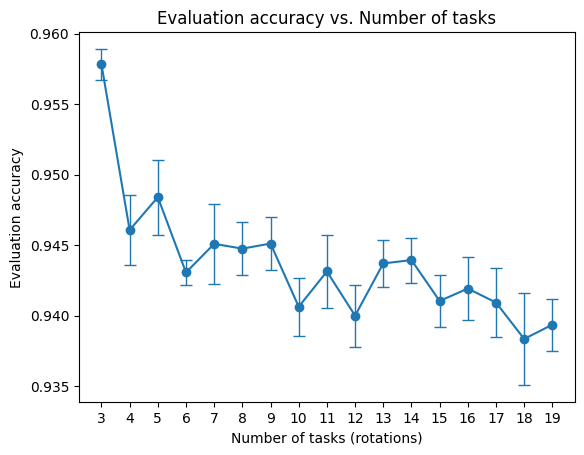

In [124]:
plot_accuracies_mean_std(accs_over_numtasks_and_runs, config, title='Evaluation accuracy vs. Number of tasks', xlabel='Number of tasks (rotations)')

2.3320458
0.042314123


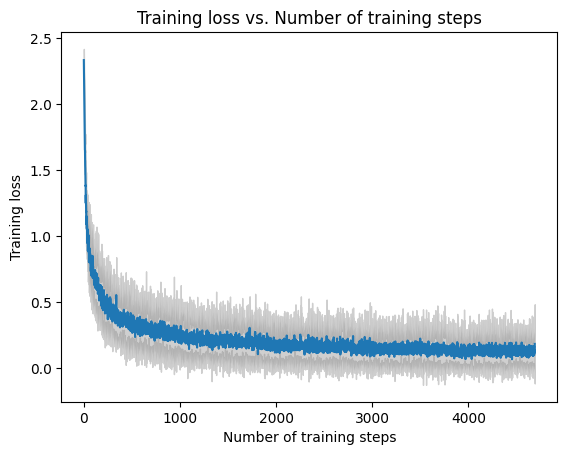

2.329642
0.031689435


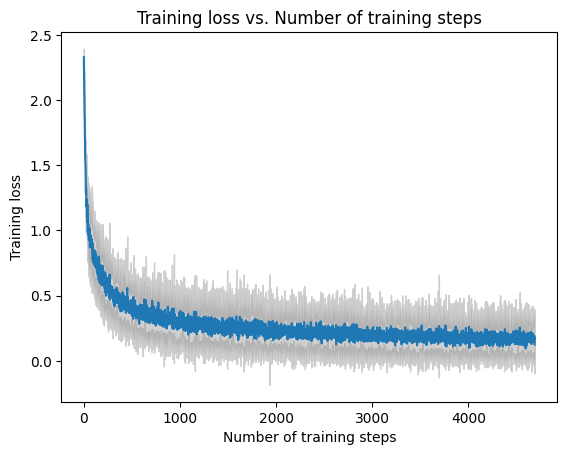

2.3386593
0.03527271


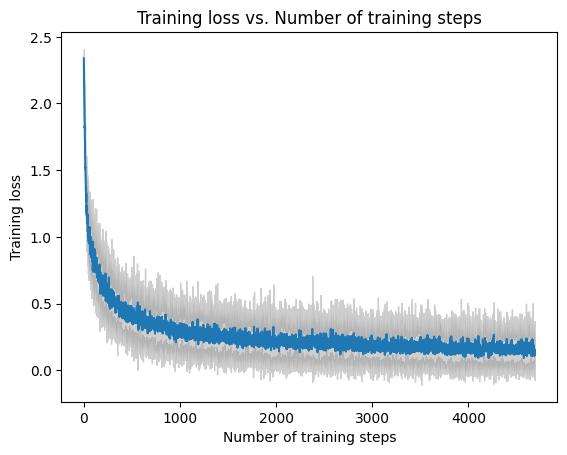

2.3126602
0.029455472


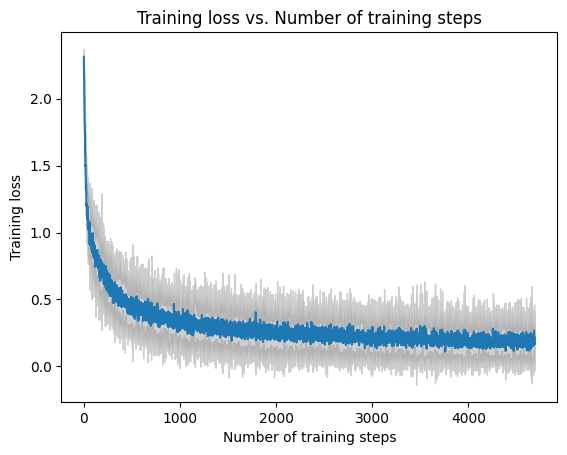

2.3293843
0.03175656


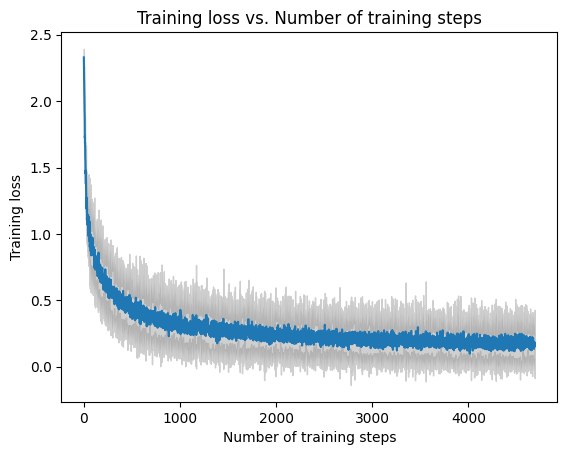

2.3425345
0.019161733


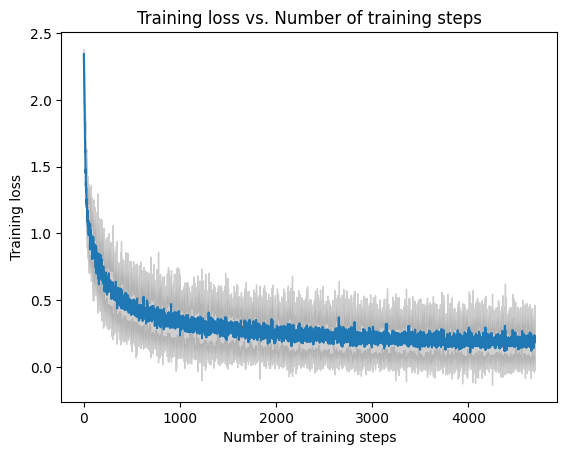

2.3254383
0.0165207


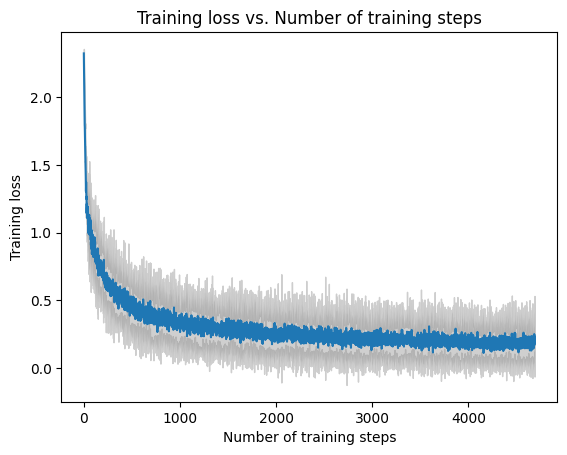

2.3346539
0.033310756


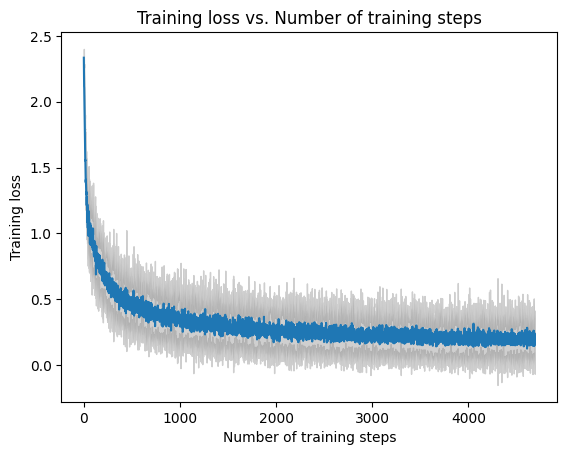

2.3341289
0.029026946


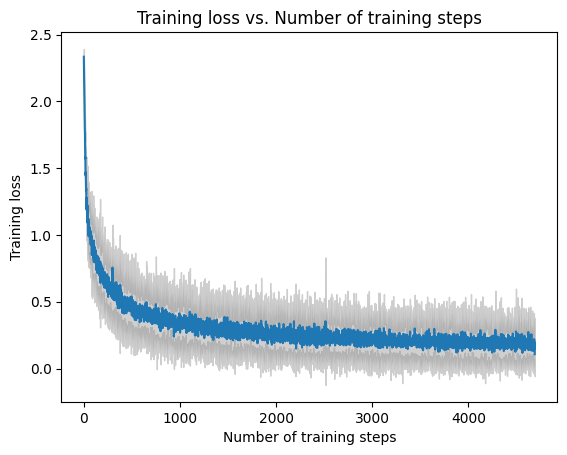

2.3209093
0.03347278


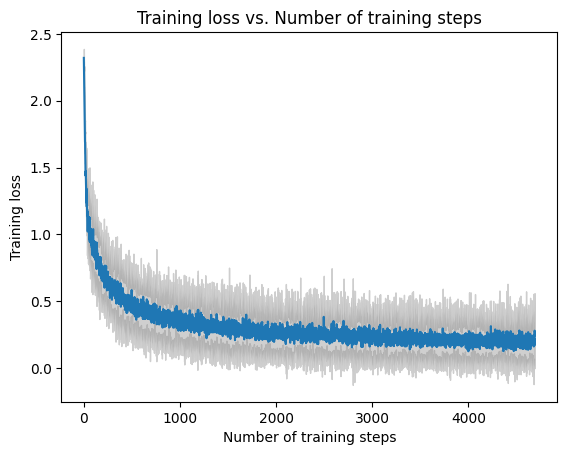

2.3365703
0.035229582


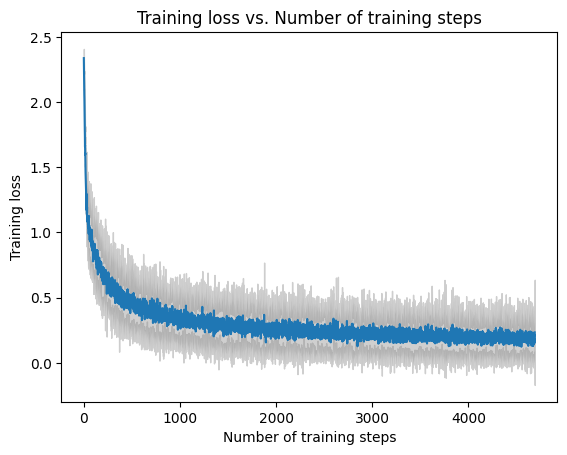

2.322974
0.024889687


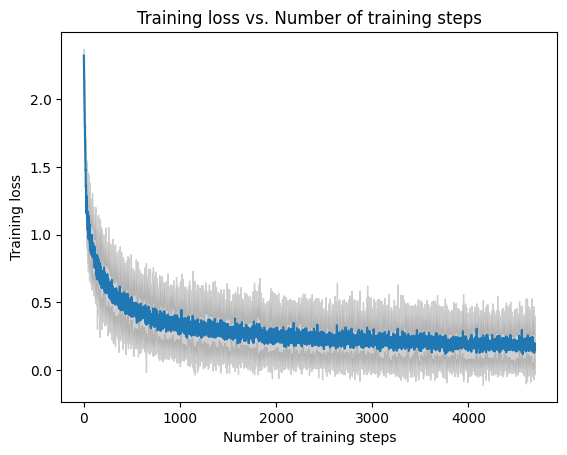

2.3215175
0.04214208


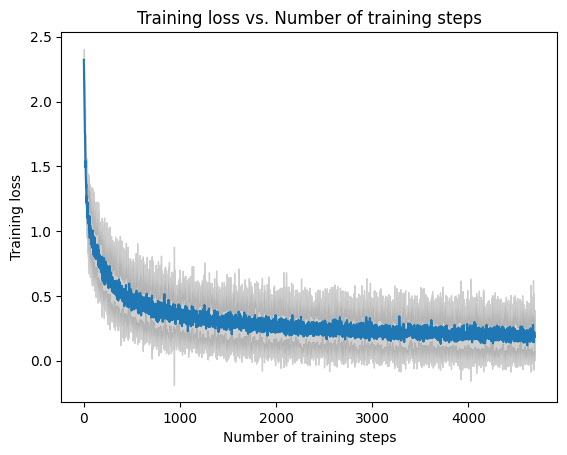

2.3292236
0.0250894


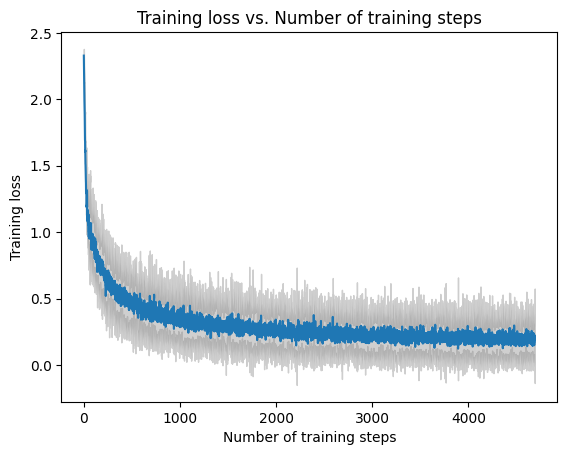

2.3224204
0.05149838


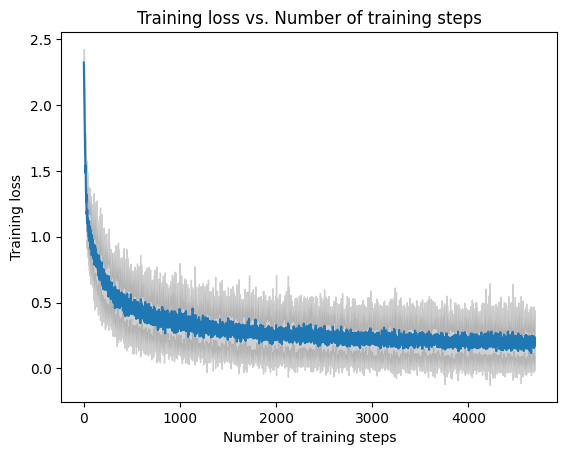

2.342344
0.030559184


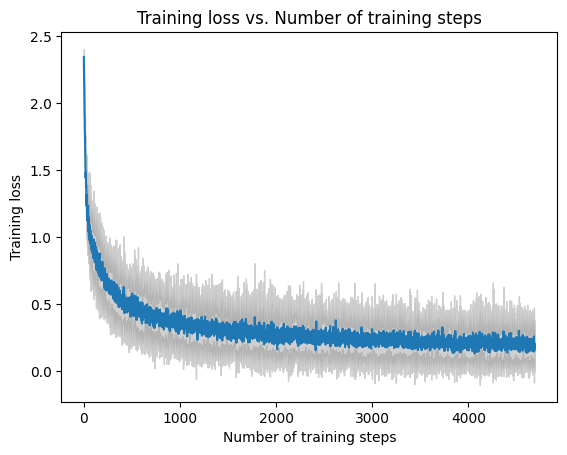

2.3344197
0.043052875


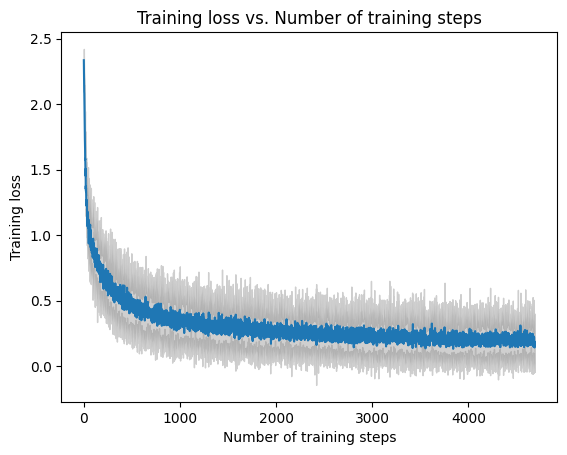

In [120]:
plot_losses_over_runs(train_losses_over_numtasks_and_runs, config)

### Accuracy vs. Distance between tasks

**NB.** Number of tasks is fixed

In [ ]:
losses = []
accuracies = []

config['num_tasks'] = 5

for per_task_rotation in range(5, 30, 5):
    config['per_task_rotation'] = per_task_rotation

    print('training a new model on ', config['num_tasks'], 'tasks, each separated by ', config['per_task_rotation'], 'degrees')

    model = SimpleNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])

    train = RotatedMNISTDataset('./data', train=True, transform=transforms,
                                        num_tasks=config['num_tasks'],
                                        per_task_rotation=config['per_task_rotation'])
    test = RotatedMNISTDataset('./data', train=False, transform=transforms,
                                        num_tasks=config['num_tasks'],
                                        per_task_rotation=config['per_task_rotation'])

    train_loader = DataLoader(train, batch_size=64, shuffle=True)
    test_loader = DataLoader(test, batch_size=64, shuffle=False)

    losses.append(train_model(model, train_loader, criterion, optimizer))
    accuracies.append(evaluate_model(model, test_loader))

training a new model on  5 tasks, each separated by  5 degrees
training a new model on  5 tasks, each separated by  10 degrees
training a new model on  5 tasks, each separated by  15 degrees
training a new model on  5 tasks, each separated by  20 degrees
training a new model on  5 tasks, each separated by  25 degrees


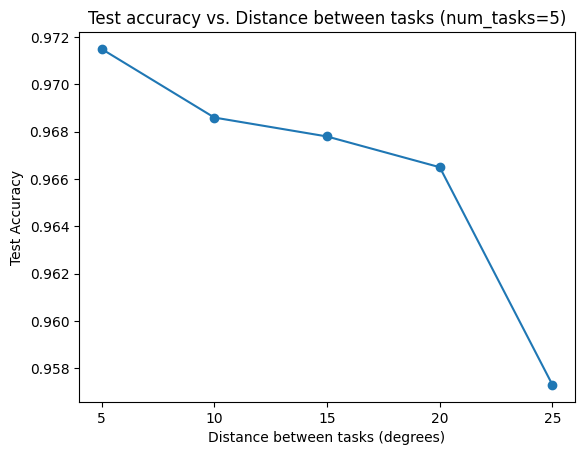

In [ ]:
plt.plot(list(range(5, 30, 5)), accuracies, marker='o')
plt.title('Test accuracy vs. Distance between tasks (num_tasks=5)')
plt.xlabel('Distance between tasks (degrees)')
plt.ylabel('Test Accuracy')
plt.xticks(list(range(5, 30, 5)))
plt.savefig('model-performance-vs-distance-between-tasks-rotated-mnist.pdf')
plt.show()


#### Multiple runs

In [128]:
train_losses_over_numtasks_and_runs = {}
accs_over_numtasks_and_runs = {}

config['num_tasks'] = 5
rounds = config['rounds']
for seed in range(rounds):
    set_seed(seed)

    for per_task_rotation in range(5, 30, 5):
        config['per_task_rotation'] = per_task_rotation

        print('training a new model on ', config['num_tasks'], 'tasks, each separated by ', config['per_task_rotation'], 'degrees')

        model = SimpleNN()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])

        train = RotatedMNISTDataset('./data', train=True, transform=transforms,
                                            num_tasks=config['num_tasks'],
                                            per_task_rotation=config['per_task_rotation'])
        test = RotatedMNISTDataset('./data', train=False, transform=transforms,
                                            num_tasks=config['num_tasks'],
                                            per_task_rotation=config['per_task_rotation'])

        train_loader = DataLoader(train, batch_size=64, shuffle=True)
        test_loader = DataLoader(test, batch_size=64, shuffle=False)

        train_loss = train_model(model, train_loader, criterion, optimizer)
        train_losses_over_numtasks_and_runs.setdefault(per_task_rotation, []).append(train_loss)
        
        accuracy = evaluate_model(model, test_loader)
        accs_over_numtasks_and_runs.setdefault(per_task_rotation, []).append(accuracy)

Random seed set as 0
training a new model on  5 tasks, each separated by  5 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  5 tasks, each separated by  10 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  5 tasks, each separated by  15 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  5 tasks, each separated by  20 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  5 tasks, each separated by  25 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Random seed set as 1
training a new model on  5 tasks, each separated by  5 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  5 tasks, each separated by  10 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  5 tasks, each separated by  15 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  5 tasks, each separated by  20 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on 

In [129]:
filename = '{}_{}_accs_over_distancebetweentasks_and_runs_{}_runs.json'.format(
    config['setting'],
    config['model_name'],
    config['rounds']
)
save_accs(accs_over_numtasks_and_runs, config, filename=filename)

['5', '10', '15', '20', '25']


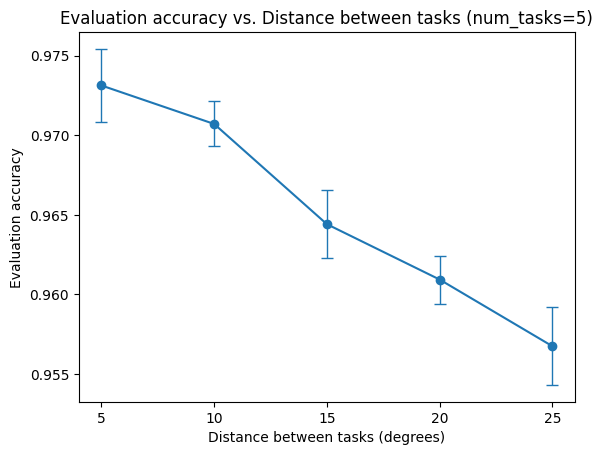

In [134]:
plot_accuracies_mean_std(accs_over_numtasks_and_runs, config, title='Evaluation accuracy vs. Distance between tasks (num_tasks=5)', xlabel='Distance between tasks (degrees)')

## e2cnn model

### Warmup: training a first model (on 8 tasks with 45° per task)

**NB** # the model (C8SteerableCNN) is equivariant under rotations by 45 degrees, modelled by C8

In [ ]:
config = {
    # ---COMMON----
    'model_name': 'C8SteerableCNN',
    'num_tasks': 8, 'per_task_rotation': 45, 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64
}

In [ ]:
#--------------------------------------------
'''
These transformations are required according to the notebook where
C8SteerableCNN come from: https://github.com/QUVA-Lab/e2cnn/blob/master/examples/model.ipynb

**NB** this is the code that has been used to train C8SteerableCNN
train_transform = Compose([
    pad,
    resize1,
    RandomRotation(180, interpolation=Image.BILINEAR, expand=False),
    resize2,
    totensor,
])

mnist_train = MnistRotDataset(mode='train', transform=train_transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64)


test_transform = Compose([
    pad,
    totensor,
])
mnist_test = MnistRotDataset(mode='test', transform=test_transform)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
'''
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import Compose

# images are padded to have shape 29x29.
# this allows to use odd-size filters with stride 2 when downsampling a feature map in the model
pad = Pad((0, 0, 1, 1), fill=0)

# to reduce interpolation artifacts (e.g. when testing the model on rotated images),
# we upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(87)
resize2 = Resize(29)
#--------------------------------------------

transforms = torchvision.transforms.Compose([
    pad,
    # resize1,  # MH not used because the rotation is performed inside RotatedMNISTDataset
    # RandomRotation(180, interpolation=Image.BILINEAR, expand=False),  # MH not used because the rotation is performed inside RotatedMNISTDataset
    resize2,
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_45deg = RotatedMNISTDataset('./data', train=True, transform=transforms,
                                    num_tasks=config['num_tasks'],
                                    per_task_rotation=config['per_task_rotation'])
test_45deg = RotatedMNISTDataset('./data', train=False, transform=transforms,
                                    num_tasks=config['num_tasks'],
                                    per_task_rotation=config['per_task_rotation'])

train_loader = DataLoader(train_45deg, batch_size=64, shuffle=True)
test_loader = DataLoader(test_45deg, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 95907725.42it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 98006224.78it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30642779.15it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8388608.00it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
model = C8SteerableCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


c= 48


In [ ]:
lc = train_model(model, train_loader, criterion, optimizer)
accuracy = evaluate_model(model, test_loader)

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4


accuracy= 0.8472


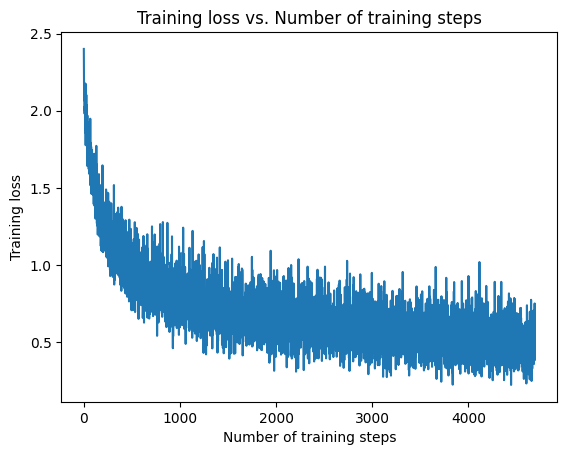

In [ ]:
print('accuracy=', accuracy)
plot_training_loss(lc, config)

# **[TODO]** Rotated MNIST: Multi-task learning setting

In [ ]:
class MultiTaskModel(nn.Module):
    def __init__(self, num_tasks):
        super(MultiTaskModel, self).__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.task_specific_layers = nn.ModuleList([nn.Linear(64, 10) for _ in range(num_tasks)])

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.shared_layers(x)
        outputs = [task_layer(x) for task_layer in self.task_specific_layers]
        return outputs


In [ ]:
!pip install torchviz

In [ ]:
model = MultiTaskModel(num_tasks=5)

from torchviz import make_dot

batch = next(iter(train_loaders[0][0]))[0]
yhat = model(batch)
print(type(yhat))
print(len(yhat))
make_dot(tuple(yhat), params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

<class 'list'>
5


'rnn_torchviz.png'

In [ ]:
print(model)

MultiTaskModel(
  (shared_layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (task_specific_layers): ModuleList(
    (0-4): 5 x Linear(in_features=64, out_features=10, bias=True)
  )
)


# Rotated MNIST: Metalearning setting

Here we use the library `Higher` to train various models in a metalearning setting

## Utility functions

In [12]:
def plot_train_validation_loss(tl, vl, config):
    #plt.plot(loss, marker='o')
    plt.plot(tl, label='training loss')
    plt.plot(vl, label='validation loss')

    plt.title('Training and Validation losses vs. Number of training steps')
    plt.xlabel('Number of training steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(config['model_name']+'_training-validation-loss-vs-number-of-training-steps-rotated-MNIST-'+str(config['per_task_rotation'])+'deg.pdf')
    plt.show()

In [13]:
def plot_accuracies(accuracies, config):
    rots, accs = [], []
    for d in accuracies:
        rots.append(d['rot'])
        accs.append(d['test_acc'])

    plt.plot(rots, accs, color='b', marker='o')
    ticks = rots

    plt.title('Evaluation accuracy vs. Rotation angle')
    plt.xlabel('Rotation angle (task)')
    plt.ylabel('Evaluation accuracy')
    plt.xticks(ticks, ticks)
    #plt.xscale('log')
    #plt.legend()
    #plt.grid()
    plt.savefig(config['model_name']+'_evaluation-accuracy-vs-rotation-angle-MNIST-'+str(config['per_task_rotation'])+'deg.pdf')
    plt.show()

In [ ]:
#!pip install higher

In [14]:
#import higher
#import time
#import scipy.stats as st


#def train(step_idx, data, net, inner_opt_builder, meta_opt, n_inner_iter):
def train(train_iterators, net, criterion, inner_opt, meta_opt, config):
    """Main meta-training step."""
    #x_spt, y_spt, x_qry, y_qry = data
    #task_num = x_spt.size()[0]
    #querysz = x_qry.size(1)

    #inner_opt = inner_opt_builder.inner_opt

    qry_losses = []
    meta_opt.zero_grad()
    for task in range(config['num_tasks']):

        x, y = next(train_iterators[task])
        x_spt, y_spt = x[:config['k_spt']], y[:config['k_spt']]
        x_qry, y_qry = x[config['k_spt']:], y[config['k_spt']:]

        with higher.innerloop_ctx(
            net,
            inner_opt,
            copy_initial_weights=False,
            #override=inner_opt_builder.overrides,
        ) as (
            fnet,
            diffopt,
        ):
            for _ in range(config['n_inner_iter']):
                spt_pred = fnet(x_spt)
                #spt_loss = F.mse_loss(spt_pred, y_spt)
                spt_loss = criterion(spt_pred, y_spt)
                diffopt.step(spt_loss)
            qry_pred = fnet(x_qry)
            #qry_loss = F.mse_loss(qry_pred, y_qry)
            qry_loss = criterion(qry_pred, y_qry)
            qry_losses.append(qry_loss.detach().cpu().numpy())
            qry_loss.backward()

    avg_qry_loss = np.mean(qry_losses)
    #metrics = {"train_loss": avg_qry_loss}
    #wandb.log(metrics, step=step_idx)
    meta_opt.step()

    return avg_qry_loss


def test(test_iterators, net, criterion, inner_opt, config):
    """Main meta-training step."""
    #x_spt, y_spt, x_qry, y_qry = data
    #task_num = x_spt.size()[0]
    #querysz = x_qry.size(1)

    #inner_opt = inner_opt_builder.inner_opt

    qry_losses = []
    for task in range(config['num_tasks']):

        x, y = next(test_iterators[task])
        x_spt, y_spt = x[:config['k_spt']], y[:config['k_spt']]
        x_qry, y_qry = x[config['k_spt']:], y[config['k_spt']:]

        with higher.innerloop_ctx(
            net, inner_opt, track_higher_grads=False, #override=inner_opt_builder.overrides,
        ) as (
            fnet,
            diffopt,
        ):
            for _ in range(config['n_inner_iter']):
                spt_pred = fnet(x_spt)
                #spt_loss = F.mse_loss(spt_pred, y_spt)
                spt_loss = criterion(spt_pred, y_spt)
                diffopt.step(spt_loss)
            qry_pred = fnet(x_qry)
            #qry_loss = F.mse_loss(qry_pred, y_qry[i])
            qry_loss = criterion(qry_pred, y_qry)
            qry_losses.append(qry_loss.detach().cpu().numpy())
    avg_qry_loss = np.mean(qry_losses)
    _low, high = st.t.interval(
        0.95, len(qry_losses) - 1, loc=avg_qry_loss, scale=st.sem(qry_losses)
    )
    test_metrics = {"test_loss": avg_qry_loss, "test_err": high - avg_qry_loss}
    #wandb.log(test_metrics, step=step_idx)
    return avg_qry_loss


"""
def meta_sample(dataloader, config):
    '''
    NB. for few shot learning, here is the procedure to generate one task and its data:
        "Sample n_way labels uniformly at random,
        and then sample n_shot + n_query items for each label, also uniformly at random.
        Yields:
            a list of indices of length (n_way * (n_shot + n_query))"

    If we adapt this sampling procedure to the rotated MNIST dataset, we will get
    the following:
        the idea is to perform some steps of gradient descent on the task i.
        Note that one gradient step is performed by getting an estimate of the
        gradient using a batch of examples from the considered task.

        `n_way`: 10 classes of MNIST
        `n_shot`: the number of examples per class
        `n_query`: the number of
    '''
    for task in range(config['num_tasks']):
        x_spt, y_spt = next(iter(train_loaders[task]['loader']))
        x_qry, y_qry = next(iter(train_loaders[task]['loader']))
"""


def train_and_evaluate_metalearning(model, train_loaders, test_loaders, criterion, config, num_epochs=5):

    meta_opt = torch.optim.Adam(model.parameters(), lr=0.001)
    inner_opt = torch.optim.Adam(model.parameters(), lr=0.001)


    train_losses = []
    val_losses = []
    start_time = time.time()
    for epoch in range(num_epochs):
        print('epoch', epoch, '...')
        #for step_idx in range(config['num_outer_steps']):

        train_iterators, test_iterators = [], []
        for task in range(config['num_tasks']):
            train_iterators.append(iter(train_loaders[task]['loader']))
            test_iterators.append(iter(test_loaders[task]['loader']))

        try:
            while True:

                #data, _filters = db.next(n_tasks=32, mode="train")
                #train(step_idx, data, net, inner_opt_builder, meta_opt, cfg.num_inner_steps)
                train_loss = train(train_iterators, model, criterion, inner_opt, meta_opt, config)
                print('Train loss:', train_loss)
                train_losses.append(train_loss)

                #if step_idx == 0 or (step_idx + 1) % 10 == 0:

                #test_data, _filters  = db.next(300, "test")
                val_loss = test(
                    test_iterators,  #test_data,
                    model,  #net,
                    criterion,
                    inner_opt,  #inner_opt_builder,
                    config,  #cfg.num_inner_steps,
                )
                '''
                if step_idx > 0:
                    steps_p_sec = (step_idx + 1) / (time.time() - start_time)
                    #wandb.log({"steps_per_sec": steps_p_sec}, step=step_idx)
                    print(f"Step: {step_idx}. Steps/sec: {steps_p_sec:.2f}")
                '''

                print('Val loss:', val_loss)
                val_losses.append(val_loss)

        except StopIteration:
            print('Iterator exhausted')


        '''
            #if cfg.problem in ["2d_rot8_flip", "2d_rot8"]:  # `plot_dataset()` is specifically designed for plotting images
            #    plot_dataset(data, task_id=-1, path='./outputs/synthetic_outputs/wandb/latest-run/files/data_at_stepidx_{}'.format(step_idx))
            #save_model(net, path='./outputs/synthetic_outputs/wandb/latest-run/files/model_at_stepidx_{}.pth'.format(step_idx))
        '''

    return train_losses, val_losses



## SimpleNN model

In [ ]:
config = {
    # ---COMMON----
    'model_name': 'SimpleNN',
    'num_tasks': 8, 'per_task_rotation': 45, 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64,\
    'k_spt': 5,\
    'n_inner_iter': 5,
}

In [ ]:
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loaders, test_loaders = create_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])
train_losses, val_losses = train_and_evaluate_metalearning(model, train_loaders, test_loaders, criterion, config)

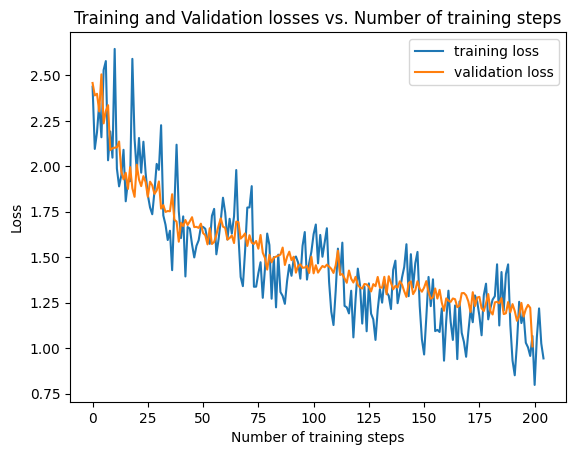

In [ ]:
plot_train_validation_loss(train_losses, val_losses, config)

### Evaluate model on each rotation angle in traditionl classification setting WITHOUT ADAPTATION

In [ ]:
accuracies = []
for test_loader in test_loaders:
    accuracy = evaluate_model(model, test_loader['loader'])
    accuracies.append({'test_acc':accuracy, 'rot':test_loader['rot']})

In [ ]:
print(accuracies)

[{'test_acc': 0.6443, 'rot': -45}, {'test_acc': 0.6171, 'rot': 0}, {'test_acc': 0.6433, 'rot': 45}, {'test_acc': 0.6215, 'rot': 90}, {'test_acc': 0.6072, 'rot': 135}, {'test_acc': 0.6123, 'rot': 180}, {'test_acc': 0.663, 'rot': 225}, {'test_acc': 0.6612, 'rot': 270}]


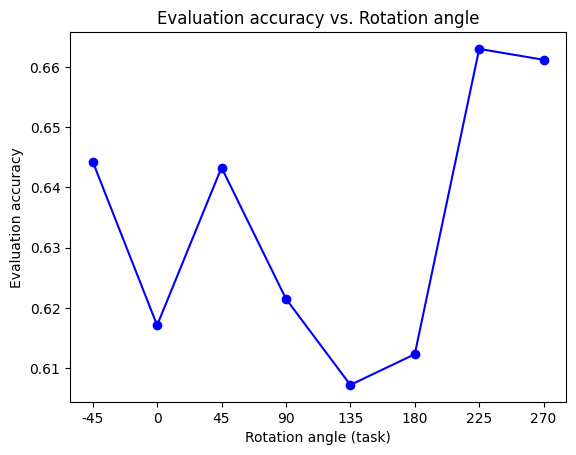

In [ ]:
plot_accuracies(accuracies, config)

### **TODO** Evaluate model on each rotation angle separately WITH ADAPTATION

## Net (SimpleCNN) model

In [15]:
config = {
    # ---COMMON----
    'model_name': 'Net_SimpleCNN',
    'num_tasks': 8, 'per_task_rotation': 45, 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64,\
    'k_spt': 5,\
    'n_inner_iter': 5,
}

In [16]:
model = Net()
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loaders, test_loaders = create_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])
train_losses, val_losses = train_and_evaluate_metalearning(model, train_loaders, test_loaders, criterion, config)

0.7%

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%
100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

epoch 0 ...
Train loss: 3.645752
Val loss: 3.187995
Train loss: 2.526894
Val loss: 2.7805882
Train loss: 2.355037
Val loss: 3.222544
Train loss: 2.3580198
Val loss: 2.5301547
Train loss: 2.3006244
Val loss: 2.4337988
Train loss: 2.6441114
Val loss: 2.3518975
Train loss: 2.6617079
Val loss: 2.3138895
Train loss: 2.2535362
Val loss: 2.2935693
Train loss: 2.2836204
Val loss: 2.275528
Train loss: 2.287776
Val loss: 2.3017147
Train loss: 2.4350953
Val loss: 2.2825842
Train loss: 2.274634
Val loss: 2.271383
Train loss: 2.2347884
Val loss: 2.2640471
Train loss: 2.2720027
Val loss: 2.2520301
Train loss: 2.2717001
Val loss: 2.2719097
Train loss: 2.2595134
Val loss: 2.229082
Train loss: 2.2256718
Val loss: 2.2312403
Train loss: 2.2085805
Val loss: 2.2066493
Train loss: 2.27031
Val loss: 2.1955767
Train loss: 2.2495813
Val loss: 2.190726
Train loss:

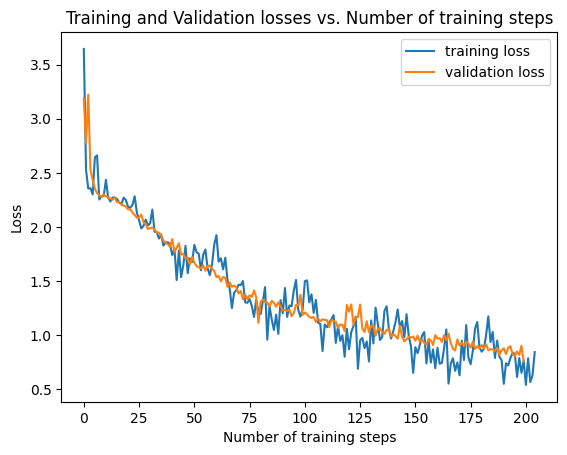

In [17]:
plot_train_validation_loss(train_losses, val_losses, config)

### Evaluate model on each rotation angle in traditionl classification setting WITHOUT ADAPTATION

In [20]:
accuracies = []
for test_loader in test_loaders:
    accuracy = evaluate_model(model, test_loader['loader'])
    accuracies.append({'test_acc':accuracy, 'rot':test_loader['rot']})

In [21]:
print(accuracies)

[{'test_acc': 0.1583, 'rot': -45}, {'test_acc': 0.1471, 'rot': 0}, {'test_acc': 0.2039, 'rot': 45}, {'test_acc': 0.2225, 'rot': 90}, {'test_acc': 0.1521, 'rot': 135}, {'test_acc': 0.152, 'rot': 180}, {'test_acc': 0.2253, 'rot': 225}, {'test_acc': 0.2399, 'rot': 270}]


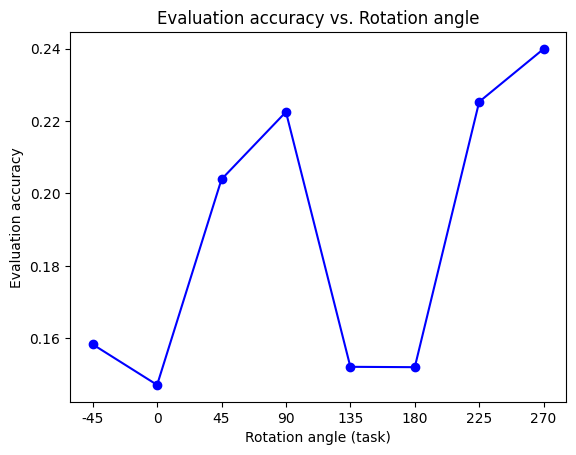

In [22]:
plot_accuracies(accuracies, config)

### Multiple runs

In [53]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [54]:
train_loaders, test_loaders = create_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])

criterion = nn.CrossEntropyLoss()

train_losses_over_runs = []
val_losses_over_runs = []
accs_over_rotangles_and_runs = {} 

rounds = 10
for seed in range(rounds):
    set_seed(seed)

    model = Net()
    train_losses, val_losses = train_and_evaluate_metalearning(model, train_loaders, test_loaders, criterion, config)

    for test_loader in test_loaders:
        accuracy = evaluate_model(model, test_loader['loader'])
        accs_over_rotangles_and_runs.setdefault(test_loader['rot'], []).append(accuracy)

    train_losses_over_runs.append(train_losses)
    val_losses_over_runs.append(val_losses)

Random seed set as 0
epoch 0 ...
Train loss: 3.645752
Val loss: 3.187995
Train loss: 2.526894
Val loss: 2.7805882
Train loss: 2.355037
Val loss: 3.222544
Train loss: 2.3580198
Val loss: 2.5301547
Train loss: 2.3006244
Val loss: 2.4337988
Train loss: 2.6441114
Val loss: 2.3518975
Train loss: 2.6617079
Val loss: 2.3138895
Train loss: 2.2535362
Val loss: 2.2935693
Train loss: 2.2836204
Val loss: 2.275528
Train loss: 2.287776
Val loss: 2.3017147
Train loss: 2.4350953
Val loss: 2.2825842
Train loss: 2.274634
Val loss: 2.271383
Train loss: 2.2347884
Val loss: 2.2640471
Train loss: 2.2720027
Val loss: 2.2520301
Train loss: 2.2717001
Val loss: 2.2719097
Train loss: 2.2595134
Val loss: 2.229082
Train loss: 2.2256718
Val loss: 2.2312403
Train loss: 2.2085805
Val loss: 2.2066493
Train loss: 2.27031
Val loss: 2.1955767
Train loss: 2.2495813
Val loss: 2.190726
Train loss: 2.1870422
Val loss: 2.1622376
Train loss: 2.1766434
Val loss: 2.1635256
Train loss: 2.203229
Val loss: 2.1326208
Train loss: 2.2

In [55]:
test_mean = np.mean(accs_over_rotangles_and_runs[45])

In [56]:
import scipy


confidence = 0.95  # Change to your desired confidence level
t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=rounds - 1)

sd = np.std(accs_over_rotangles_and_runs[45], ddof=1)
se = sd / np.sqrt(rounds)

ci_length = t_value * se

ci_lower = test_mean - ci_length
ci_upper = test_mean + ci_length

print(ci_lower, ci_upper)

0.08905570435788099 0.18850429564211899


In [57]:
def plot_accuracies_mean_std(accuracies, config):
    rots = accuracies.keys()
    means = []
    stds = []
    for rot, accs in accuracies.items():
        means.append(np.mean(accs))
        stds.append(np.std(accs))

    plt.errorbar(rots, means, yerr=stds, capsize=4, elinewidth=1, markeredgewidth=1, fmt='-o')
    #plt.plot(rots, accs, color='b', marker='o')
    ticks = list(rots)
    print(ticks)

    plt.title('Evaluation accuracy vs. Rotation angle')
    plt.xlabel('Rotation angle (task)')
    plt.ylabel('Evaluation accuracy')
    plt.xticks(ticks, ticks)
    #plt.xscale('log')
    #plt.legend()
    #plt.grid()
    plt.savefig(config['model_name']+'_evaluation-accuracy-vs-rotation-angle-MNIST-'+str(config['per_task_rotation'])+'deg.pdf')
    plt.show()

In [59]:
print(accs_over_rotangles_and_runs)

{-45: [0.1583, 0.102, 0.0974, 0.1157, 0.1014, 0.0975, 0.1786, 0.0975, 0.3126, 0.1032], 0: [0.1471, 0.1123, 0.0975, 0.176, 0.1029, 0.0975, 0.1909, 0.0977, 0.3328, 0.1032], 45: [0.2039, 0.0967, 0.0974, 0.1125, 0.1016, 0.0974, 0.1708, 0.0981, 0.3062, 0.1032], 90: [0.2225, 0.1044, 0.0974, 0.1363, 0.1069, 0.0974, 0.1293, 0.1007, 0.2948, 0.1032], 135: [0.1521, 0.0979, 0.0974, 0.1276, 0.1039, 0.0975, 0.1717, 0.0976, 0.3026, 0.1032], 180: [0.152, 0.1148, 0.0974, 0.1549, 0.1044, 0.0974, 0.1843, 0.0979, 0.3394, 0.1032], 225: [0.2253, 0.0967, 0.0974, 0.1141, 0.1018, 0.0974, 0.183, 0.0988, 0.3171, 0.1032], 270: [0.2399, 0.1004, 0.0974, 0.1185, 0.1039, 0.0979, 0.1843, 0.1008, 0.3267, 0.1032]}


[-45, 0, 45, 90, 135, 180, 225, 270]


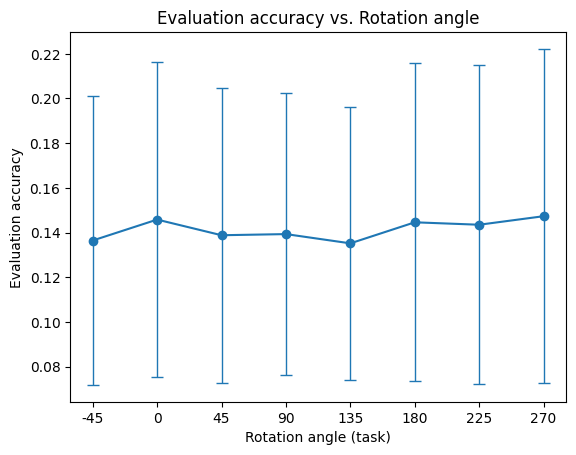

In [58]:
plot_accuracies_mean_std(accs_over_rotangles_and_runs, config)

## MSR (W/O Meta-Optimization)

Without meta-optimization, i.e., symmetry parameters and task specific parameters are treated equally

In [21]:
config = {
    # ---COMMON----
    'model_name': 'MSR_withoutMetaOpt',
    'num_tasks': 8, 'per_task_rotation': 45, 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64,\
    'k_spt': 5,\
    'n_inner_iter': 5,
}

In [22]:
model = MSR()
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loaders, test_loaders = create_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])
train_losses, val_losses = train_and_evaluate_metalearning(model, train_loaders, test_loaders, criterion, config)

epoch 0 ...
Train loss: 3.7963219
Val loss: 3.3823762
Train loss: 2.5556903
Val loss: 3.116343
Train loss: 2.4874742
Val loss: 2.9679952
Train loss: 2.4869525
Val loss: 2.6521928
Train loss: 2.3200822
Val loss: 2.4402041
Train loss: 2.4019363
Val loss: 2.3025486
Train loss: 3.008118
Val loss: 2.3698454
Train loss: 2.2685652
Val loss: 2.3142185
Train loss: 2.4324703
Val loss: 2.3075356
Train loss: 2.2910268
Val loss: 2.310652
Train loss: 2.5347266
Val loss: 2.3048656
Train loss: 2.2961702
Val loss: 2.2821128
Train loss: 2.2592535
Val loss: 2.2777324
Train loss: 2.2860618
Val loss: 2.2761855
Train loss: 2.263599
Val loss: 2.2712002
Train loss: 2.2680135
Val loss: 2.2668982
Train loss: 2.2696018
Val loss: 2.2655778
Train loss: 2.2585988
Val loss: 2.2465487
Train loss: 2.3045826
Val loss: 2.247351
Train loss: 2.296348
Val loss: 2.2455316
Train loss: 2.2320313
Val loss: 2.2339325
Train loss: 2.2452579
Val loss: 2.2210865
Train loss: 2.2587593
Val loss: 2.2181735
Train loss: 2.2476628
Val lo

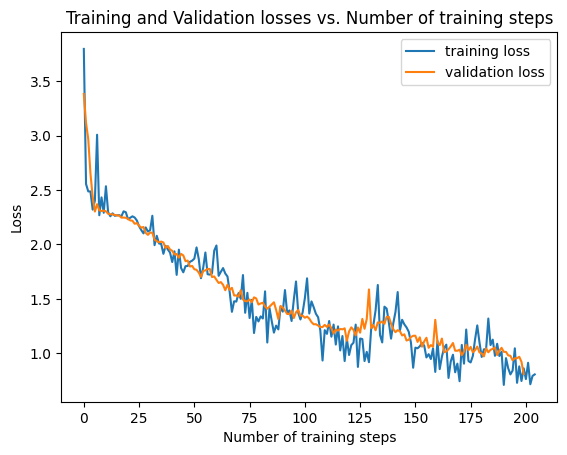

In [23]:
plot_train_validation_loss(train_losses, val_losses, config)

### Evaluate model on each rotation angle in traditionl classification setting WITHOUT ADAPTATION

In [24]:
accuracies = []
for test_loader in test_loaders:
    accuracy = evaluate_model(model, test_loader['loader'])
    accuracies.append({'test_acc':accuracy, 'rot':test_loader['rot']})

In [25]:
print(accuracies)

[{'test_acc': 0.1171, 'rot': -45}, {'test_acc': 0.1107, 'rot': 0}, {'test_acc': 0.104, 'rot': 45}, {'test_acc': 0.1097, 'rot': 90}, {'test_acc': 0.1114, 'rot': 135}, {'test_acc': 0.111, 'rot': 180}, {'test_acc': 0.115, 'rot': 225}, {'test_acc': 0.1135, 'rot': 270}]


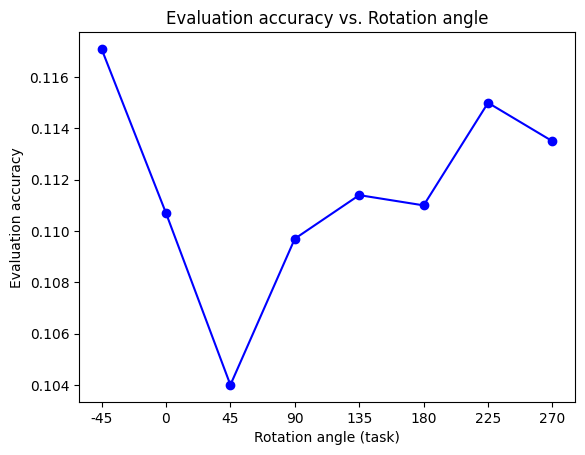

In [26]:
plot_accuracies(accuracies, config)

## MSR (W Meta-Optimization)

With meta-optimization, i.e., symmetry parameters and task specific parameters are treated differently using two completely different optimizers (`inner_opt` and `meta_opt`)

In [ ]:
config = {
    # ---COMMON----
    'model_name': 'MSR_withMetaOpt',
    'num_tasks': 8, 'per_task_rotation': 45, 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64,\
    'k_spt': 5,\
    'n_inner_iter': 5,
}

## InnerOptBuilder Class

In [ ]:
"""Custom inner loop optimizers for use with higher."""
#import collections
#import torch
#from torch.optim import SGD, Adam


def is_warp_layer(name):
    return "warp" in name


NAME_TO_INNER_OPT_CLS = {
    "maml": SGD,
    "maml_adam": Adam,
}


# TODO(allanz): Refactor into a module (or several), similar to ebn in higher/examples.
class InnerOptBuilder:
    def __init__(self, network, device, opt_name, init_lr, init_mode, lr_mode, ext_metaparams=None):
        self.network = network
        self.opt_name = opt_name
        self.init_lr = init_lr
        self.init_mode = init_mode
        self.lr_mode = lr_mode
        # metaparams that are not neural network params (e.g., learned lrs)
        if ext_metaparams:
            self.ext_metaparams = ext_metaparams
        else:
            self.ext_metaparams = self.make_ext_metaparams(device)
        self.inner_opt_cls = NAME_TO_INNER_OPT_CLS[opt_name]
        self.inner_opt = NAME_TO_INNER_OPT_CLS[opt_name](self.param_groups, lr=self.init_lr)

    def make_ext_metaparams(self, device):
        ext_metaparams = {}
        for name, param in self.network.named_parameters():
            if is_warp_layer(name) or not param.requires_grad:
                # Ignore symmetry params in the inner loop.
                continue
            if self.lr_mode == "per_layer":
                inner_lr = torch.tensor(self.init_lr).to(device)
                inner_lr.requires_grad = True
                ext_metaparams[f"{name}_lr"] = inner_lr
            elif self.lr_mode == "per_param":
                inner_lr = self.init_lr * torch.ones_like(param).to(device)
                inner_lr.requires_grad = True
                ext_metaparams[f"{name}_lr"] = inner_lr
            elif self.lr_mode == "fixed":
                pass
            else:
                raise ValueError(f"Unrecognized lr_mode: {self.lr_mode}")
        return ext_metaparams

    @property
    def metaparams(self):
        metaparams = {}
        metaparams.update(self.ext_metaparams)
        for name, param in self.network.named_parameters():
            if is_warp_layer(name) or self.init_mode == "learned":
                metaparams[name] = param
        return metaparams

    @property
    def param_groups(self):
        param_groups = []
        for name, param in self.network.named_parameters():
            if is_warp_layer(name) or not param.requires_grad:
                # Ignore symmetry params in the inner loop.
                continue
            param_groups.append({"params": param})
        return param_groups

    @property
    def overrides(self):
        overrides = collections.defaultdict(list)
        for name, param in self.network.named_parameters():
            if is_warp_layer(name) or not param.requires_grad:
                # Ignore symmetry params in the inner loop.
                continue
            if self.lr_mode == "per_layer":
                overrides["lr"].append(self.ext_metaparams[f"{name}_lr"])
            elif self.lr_mode == "per_param":
                overrides["lr"].append(self.ext_metaparams[f"{name}_lr"])
            elif self.lr_mode == "fixed":
                pass
            else:
                raise ValueError(f"Unrecognized lr_mode: {self.lr_mode}")
        return overrides



In [ ]:
model = MSR()
criterion = nn.CrossEntropyLoss()

#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
inner_opt_builder = InnerOptBuilder(
    #net, device, cfg.inner_opt, cfg.init_inner_lr, "learned", cfg.lr_mode
    net, device, "maml_adam", 0.1, "learned", "per_layer"
)
meta_opt = optim.Adam(inner_opt_builder.metaparams.values(), lr=0.001)


train_loaders, test_loaders = create_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])
train_losses, val_losses = train_and_evaluate_metalearning(model, train_loaders, test_loaders, criterion, config)

epoch 0 ...
Train loss: 3.7963223
Val loss: 3.388397
Train loss: 2.5570655
Val loss: 3.1061213
Train loss: 2.4712377
Val loss: 2.9784038
Train loss: 2.4758887
Val loss: 2.676724
Train loss: 2.3225403
Val loss: 2.4426033
Train loss: 2.4007263
Val loss: 2.3038464
Train loss: 3.2539084
Val loss: 2.3823247
Train loss: 2.2715504
Val loss: 2.316751
Train loss: 2.4598827
Val loss: 2.3236942
Train loss: 2.2988198
Val loss: 2.3303714
Train loss: 2.604097
Val loss: 2.316657
Train loss: 2.3084846
Val loss: 2.2906728
Train loss: 2.255502
Val loss: 2.2791786
Train loss: 2.2874393
Val loss: 2.2760742
Train loss: 2.25074
Val loss: 2.2762172
Train loss: 2.262233
Val loss: 2.2622004
Train loss: 2.2740836
Val loss: 2.2609756
Train loss: 2.257553
Val loss: 2.2389517
Train loss: 2.3152037
Val loss: 2.245366
Train loss: 2.3057754
Val loss: 2.2478447
Train loss: 2.2437825
Val loss: 2.24109
Train loss: 2.2400255
Val loss: 2.221294
Train loss: 2.2569373
Val loss: 2.217564
Train loss: 2.2436962
Val loss: 2.197

In [ ]:
plot_train_validation_loss(train_losses, val_losses, config)

### Evaluate model on each rotation angle in traditionl classification setting WITHOUT ADAPTATION

In [ ]:
accuracies = []
for test_loader in test_loaders:
    accuracy = evaluate_model(model, test_loader['loader'])
    accuracies.append({'test_acc':accuracy, 'rot':test_loader['rot']})

In [ ]:
print(accuracies)

In [ ]:
plot_accuracies(accuracies, config)

# Rotated MNIST: Continual learning setting

## Utility functions

In [ ]:
def plot_accuracy_evolution(matEval, config):
    for task in range(config['num_tasks']):
        plt.plot(list(range(task, config['num_tasks'])), matEval[task:, task],
                 label='task '+str(task), marker='o')

    plt.title('Rotated MNIST Continual learning setting')
    plt.xlabel('Tasks learned so far')
    plt.xticks(list(range(config['num_tasks'])))
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(config['model_name']+'_num-tasks'+str(config['num_tasks'])+'_per-task-rotation'+str(config['per_task_rotation'])+'_rotated-mnist-cl-setting.pdf')
    plt.show()

In [ ]:
def train_and_eval_continually(model, train_loaders, test_loaders criterion, optimizer, config):
    losses = []
    matEval = np.zeros((config['num_tasks'], config['num_tasks']))

    for task in range(config['num_tasks']):
        print('training on task', task)

        loss = train_model(model, train_loaders[task]['loader'], criterion, optimizer)
        losses.append({'train_loss':loss, 'rot': train_loaders[task]['rot']})

        for old_task in (range(task+1)):
            print('evaluation of the model on task', old_task)
            accuracy = evaluate_model(model, test_loaders[old_task]['loader'])

            # organize results into matrix representation following [1]
            # [1] Gradient Episodic Memory for Continual Learning
            matEval[task, old_task] = accuracy

    return losses, matEval

## SimpleNN model

In [ ]:
config = {
    # ---COMMON----
    'model_name': 'SimpleNN',
    'num_tasks': 8, 'per_task_rotation': 45, 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64
}

In [ ]:
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loaders, test_loaders = create_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])
losses, matEval = train_and_eval_continually(model, train_loaders, test_loaders, criterion, optimizer, config)

100%|██████████| 9912422/9912422 [00:00<00:00, 189977021.49it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 38689138.88it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 112892238.07it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16522574.82it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

training on task 0
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
evaluation of the model on task 0
training on task 1
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
evaluation of the model on task 0
evaluation of the model on task 1
training on task 2
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
evaluation of the model on task 0
evaluation of the model on task 1
evaluation of the model on task 2
training on task 3
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
evaluation of the model on task 0
evaluation of the model on task 1
evaluation of the model on task 2
evaluation of the model on task 3
training on task 4
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
evaluation of the model on task 0
evaluation of the model on task 1
evaluation of the model on task 2
evaluation of the model on task 3
evaluation of the model on task 4
training on task 5
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
evaluation of the model on task 0
evaluation of the model on 

In [ ]:
print(matEval)

[[0.9698 0.     0.     0.     0.     0.     0.     0.    ]
 [0.5184 0.971  0.     0.     0.     0.     0.     0.    ]
 [0.1901 0.5212 0.9674 0.     0.     0.     0.     0.    ]
 [0.2389 0.1998 0.5252 0.9717 0.     0.     0.     0.    ]
 [0.3096 0.2134 0.2408 0.5377 0.9726 0.     0.     0.    ]
 [0.2784 0.3485 0.2498 0.2252 0.5364 0.9694 0.     0.    ]
 [0.1236 0.2556 0.3521 0.2755 0.2643 0.5513 0.9715 0.    ]
 [0.4702 0.1482 0.259  0.3354 0.2405 0.2614 0.6001 0.97  ]]


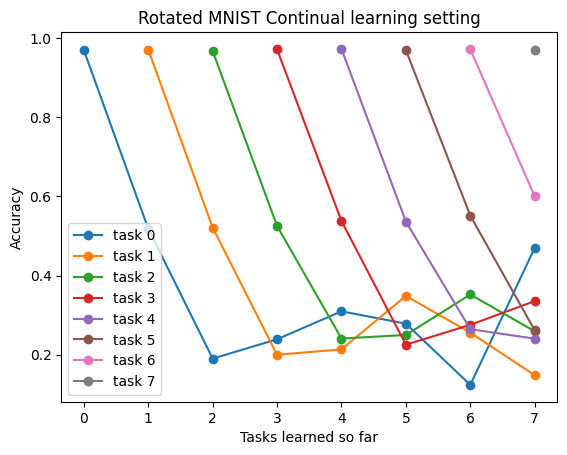

In [ ]:
plot_accuracy_evolution(matEval, config)

## e2cnn model

In [ ]:
config = {
    # ---COMMON----
    'model_name': 'C8SteerableCNN',
    'num_tasks': 8, 'per_task_rotation': 45, 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64
}

In [ ]:
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import Compose

# images are padded to have shape 29x29.
# this allows to use odd-size filters with stride 2 when downsampling a feature map in the model
pad = Pad((0, 0, 1, 1), fill=0)

# to reduce interpolation artifacts (e.g. when testing the model on rotated images),
# we upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(87)
resize2 = Resize(29)
#--------------------------------------------

transform = [
    pad,
    resize2
]
train_loaders, test_loaders = create_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'], transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 205588302.53it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 77551660.58it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 75194800.61it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15375729.43it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
model = C8SteerableCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses, matEval = train_and_eval_continually(model, train_loaders, test_loaders, criterion, optimizer, config)

/usr/local/lib/python3.10/dist-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


c= 48
training on task 0
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
evaluation of the model on task 0
training on task 1
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
evaluation of the model on task 0
evaluation of the model on task 1
training on task 2
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
evaluation of the model on task 0
evaluation of the model on task 1
evaluation of the model on task 2
training on task 3
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
evaluation of the model on task 0
evaluation of the model on task 1
evaluation of the model on task 2
evaluation of the model on task 3
training on task 4
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
evaluation of the model on task 0
evaluation of the model on task 1
evaluation of the model on task 2
evaluation of the model on task 3
evaluation of the model on task 4
training on task 5
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
evaluation of the model on task 0
evaluation of the model on task 1
evaluation of the model on task 2
evaluation of the model on t

In [ ]:
print(matEval)

[[0.9569 0.     0.     0.     0.     0.     0.     0.    ]
 [0.5359 0.9674 0.     0.     0.     0.     0.     0.    ]
 [0.2062 0.5724 0.9703 0.     0.     0.     0.     0.    ]
 [0.3063 0.208  0.6049 0.9686 0.     0.     0.     0.    ]
 [0.4084 0.3502 0.2391 0.5729 0.9712 0.     0.     0.    ]
 [0.4085 0.4271 0.3449 0.2554 0.7206 0.962  0.     0.    ]
 [0.299  0.3743 0.4624 0.344  0.3762 0.6744 0.963  0.    ]
 [0.7078 0.289  0.3447 0.4232 0.3561 0.3236 0.5991 0.9653]]


TypeError: can only concatenate str (not "int") to str

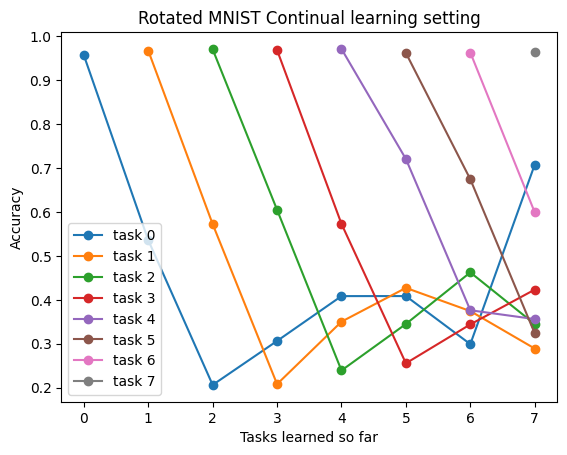

In [ ]:
plot_accuracy_evolution(matEval, config)

## Net (SimpleCNN) model

In [ ]:
config = {
    # ---COMMON----
    'model_name': 'SimpleCNN',
    'num_tasks': 8, 'per_task_rotation': 45, 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64
}

In [ ]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loaders, test_loaders = create_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])
losses, matEval = train_and_eval_continually(model, train_loaders, test_loaders, criterion, optimizer, config)

100%|██████████| 9912422/9912422 [00:00<00:00, 111460642.25it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 16294820.26it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 28171325.56it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4284869.27it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

training on task 0
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
evaluation of the model on task 0
training on task 1
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
evaluation of the model on task 0
evaluation of the model on task 1
training on task 2
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
evaluation of the model on task 0
evaluation of the model on task 1
evaluation of the model on task 2
training on task 3
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
evaluation of the model on task 0
evaluation of the model on task 1
evaluation of the model on task 2
evaluation of the model on task 3
training on task 4
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
evaluation of the model on task 0
evaluation of the model on task 1
evaluation of the model on task 2
evaluation of the model on task 3
evaluation of the model on task 4
training on task 5
epoch 0
epoch 1
epoch 2


In [ ]:
print(matEval)

In [ ]:
plot_accuracy_evolution(matEval, config)